# Culture Optimization - 3T-9L1R

### **3T-9L1R: 3 Teams composed of 9 agents (3, 3, 3) and 1 Random Agent**

This is to make the 3 teams more evenly matched - each team is composed of 3 agents.

We perform cultural parameter optimization search on the 5 cultures and examin how they affect the behaviors of these teams.

In [5]:
import os
import random
import time
import pickle
import platform
import torch
import gym
import numpy as np

# This is the Gathering Game Environment based on Tribal Organization of agents
from tribes_env import GatheringEnv
from tribes_model import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


## Culture = Individualist (Baseline)

Run finish_episode() specific to this culture.

In [2]:
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    total_norms = [0 for i in range(num_learners)]
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    T_reward = []

   
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        for t in tribes:
            if t.name is learners[i].tribe:
                T_reward = t.tribal_awards()
                
                # For debug only
                # print('Agent{} receives tribal award from Tribe{}'.format(i,t.name))
                # print (T_reward)
                # print (learners[i].rewards)
        
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # The agent is incentivized to cooperate by an award of 30% of what the tribe takes
            # in by all its members
            R = r + T + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norms[i] = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        
    # clear all agent's history only at the end of episode; they are needed for tribal reward calc
    for i in range(num_learners):
        learners[i].clear_history()


    return total_norms


In [5]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 9 learning agents, 0 trained agents, 1 random agents
num_learners = 9
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 10000
max_frames = 300
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 100
save_interval = 500

def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

# Cultural parameter search
cultures =[ {'name':'individualist'}]

for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("Learning with trained agents - not implemented yet!")
            raise
            """
            Disable for now! No need to train with trained agents.
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-9L1R/'
                results_dir = 'results/3T-9L1R/'

                model_file = model_dir+'{}/MA{}_{}__ep{}.p'.format(culture['name'], i, game, ep+prior_eps+1)
                data_file = results_dir+'{}/MA{}_{}.p'.format(culture['name'], i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Learner agent 8
Load random agent 9
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.03429
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.03546
Learner:5	Reward total:0	Running mean: 0.008687
Learner:6	Reward total:0	Running mean: 0.06108
Learner:7	Reward total:0	Running mean: 0.05054
Learner:8	Reward total:0	Running mean: 0.2447
Max Norms =  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:0	Running mean: 0.04837
Learner:1	Reward total:0	Running mean: 0.0
Learn

Max Norms =  ['57.32', '94.10', '118.73', '32.70', '82.06', '60.94', '68.47', '48.94', '91.51']
....................................................................................................
Episode 1400 complete
Learner:0	Reward total:1	Running mean: 3.798
Learner:1	Reward total:4	Running mean: 3.582
Learner:2	Reward total:0	Running mean: 4.991
Learner:3	Reward total:2	Running mean: 7.258
Learner:4	Reward total:28	Running mean: 18.88
Learner:5	Reward total:1	Running mean: 9.301
Learner:6	Reward total:39	Running mean: 14.66
Learner:7	Reward total:0	Running mean: 26.4
Learner:8	Reward total:17	Running mean: 18.08
Max Norms =  ['79.21', '47.83', '0.00', '60.34', '67.21', '59.32', '81.99', '0.00', '127.64']
....................................................................................................
Episode 1500 complete
Learner:0	Reward total:3	Running mean: 4.39
Learner:1	Reward total:1	Running mean: 3.47
Learner:2	Reward total:9	Running mean: 5.569
Learner:3	Reward total:1

....................................................................................................
Episode 2700 complete
Learner:0	Reward total:9	Running mean: 5.163
Learner:1	Reward total:4	Running mean: 5.082
Learner:2	Reward total:12	Running mean: 6.156
Learner:3	Reward total:1	Running mean: 6.369
Learner:4	Reward total:6	Running mean: 24.54
Learner:5	Reward total:12	Running mean: 13.73
Learner:6	Reward total:39	Running mean: 15.79
Learner:7	Reward total:18	Running mean: 16.35
Learner:8	Reward total:21	Running mean: 13.62
Max Norms =  ['27.03', '9.65', '45.13', '58.57', '76.76', '93.37', '81.07', '63.52', '70.04']
....................................................................................................
Episode 2800 complete
Learner:0	Reward total:4	Running mean: 4.895
Learner:1	Reward total:15	Running mean: 4.96
Learner:2	Reward total:1	Running mean: 6.006
Learner:3	Reward total:3	Running mean: 6.639
Learner:4	Reward total:40	Running mean: 23.6
Learner:5	Reward total:15

....................................................................................................
Episode 5300 complete
Learner:0	Reward total:4	Running mean: 5.413
Learner:1	Reward total:11	Running mean: 5.661
Learner:2	Reward total:6	Running mean: 6.316
Learner:3	Reward total:2	Running mean: 4.592
Learner:4	Reward total:29	Running mean: 42.26
Learner:5	Reward total:32	Running mean: 14.8
Learner:6	Reward total:9	Running mean: 13.21
Learner:7	Reward total:9	Running mean: 16.39
Learner:8	Reward total:2	Running mean: 15.2
Max Norms =  ['17.18', '14.78', '58.79', '26.09', '189.50', '93.54', '39.17', '88.54', '115.99']
....................................................................................................
Episode 5400 complete
Learner:0	Reward total:7	Running mean: 4.869
Learner:1	Reward total:26	Running mean: 6.297
Learner:2	Reward total:2	Running mean: 5.809
Learner:3	Reward total:1	Running mean: 5.118
Learner:4	Reward total:26	Running mean: 40.75
Learner:5	Reward total:2

....................................................................................................
Episode 7900 complete
Learner:0	Reward total:1	Running mean: 4.093
Learner:1	Reward total:1	Running mean: 6.113
Learner:2	Reward total:3	Running mean: 2.988
Learner:3	Reward total:17	Running mean: 10.66
Learner:4	Reward total:38	Running mean: 31.52
Learner:5	Reward total:9	Running mean: 11.63
Learner:6	Reward total:4	Running mean: 9.725
Learner:7	Reward total:0	Running mean: 10.38
Learner:8	Reward total:15	Running mean: 20.34
Max Norms =  ['97.64', '11.74', '0.25', '103.56', '65.34', '69.28', '81.60', '0.00', '49.80']
....................................................................................................
Episode 8000 complete
Learner:0	Reward total:1	Running mean: 4.064
Learner:1	Reward total:16	Running mean: 6.173
Learner:2	Reward total:2	Running mean: 2.8
Learner:3	Reward total:12	Running mean: 8.481
Learner:4	Reward total:36	Running mean: 29.11
Learner:5	Reward total:0	R

Load AI agent 0
Load AI agent 1
Load AI agent 2
Load AI agent 3
Load AI agent 4
Load AI agent 5
Load AI agent 6
Load AI agent 7
Load AI agent 8
results/3T-9L1R/individualist/
Max. Running Reward - MA0 Ind Reward: 6.323
Max. Running Reward - MA1 Ind Reward: 8.747
Max. Running Reward - MA2 Ind Reward: 7.458
Max. Running Reward - MA3 Ind Reward: 12.758
Max. Running Reward - MA4 Ind Reward: 53.226
Max. Running Reward - MA5 Ind Reward: 19.930
Max. Running Reward - MA6 Ind Reward: 22.584
Max. Running Reward - MA7 Ind Reward: 33.295
Max. Running Reward - MA8 Ind Reward: 35.512
Max. Running Reward - All Agents: 125.507
Tribe 0 Sum Reward: 20.918
Tribe 1 Sum Reward: 69.899
Tribe 2 Sum Reward: 82.883




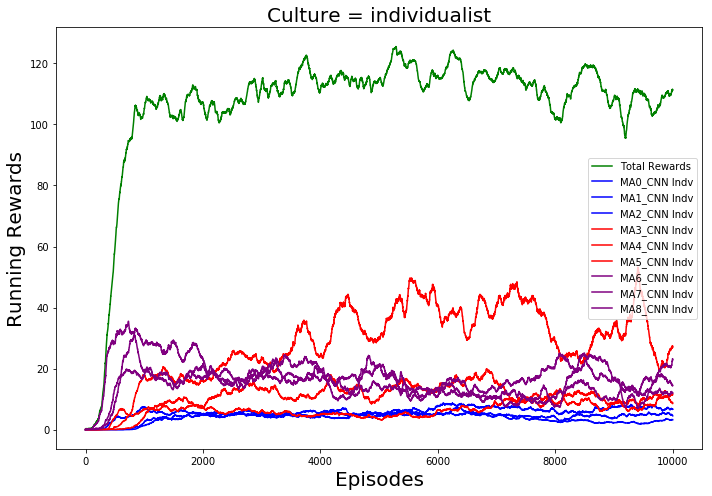

In [3]:
game = 'Gathering'

dir_names = ["results/3T-9L1R/individualist/"]

num_learners = 9
num_tribes = 3

# Cultural parameter search
culture = 'individualist'

agents = []
for i in range(num_learners):
    print("Load AI agent {}".format(i))
    agents.append(Policy(4, 8, i))

agents.append(Rdn_Policy())

# Establish tribal association

tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


# 9 agents in 4 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]


for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]
    tribe_data = [[] for i in range(num_tribes)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_Gather.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)

    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Max. Running Reward - MA{} Ind Reward: {:.3f}'.format(i, max(data[i])))

    
    print('Max. Running Reward - All Agents: {:.3f}'.format(max(total)))

    tribe_data[0] = [sum(x) for x in zip(data[0],data[1],data[2])]
    tribe_data[1] = [sum(x) for x in zip(data[3],data[4],data[5])]
    tribe_data[2] = [sum(x) for x in zip(data[6],data[7],data[8])]

    for i in range(num_tribes):
        print('Tribe {} Sum Reward: {:.3f}'.format(i, max(tribe_data[i])))
    
    print ('\n')

    plt.figure(figsize=(10, 7))
    
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('Culture = {}'.format(culture), fontsize=20)
    plt.xlabel('Episodes', fontsize=20)
    plt.ylabel('Running Rewards', fontsize=20)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Culture = Warlike

Run finish_episode() specific to this culture.

In [89]:
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    total_norms = [0 for i in range(num_learners)]
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    T_reward = []

   
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        for t in tribes:
            if t.name is learners[i].tribe:
                T_reward = t.tribal_awards(US_hits = learners[i].US_hits,THEM_hits = learners[i].THEM_hits)
 
                # For debug only
                # print('Agent{} receives tribal award from Tribe{}'.format(i,t.name))
                # print (T_reward)
                # print (learners[i].rewards)
                
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # The agent is incentivized to cooperate by an award of 30% of what the tribe takes
            # in by all its members
            R = r + T + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norms[i] = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        learners[i].clear_history()   # clear an agent's history at the end of episode


    return total_norms

## Special Case - Warlike Culture

We discovered that if we run training of only 300 game steps, the agents with Warlike culture will spend the 1st hundreds of steps in mutually assured destruction - a field of deadly crossfire which they cannot escape out of.

So we lengthen the game step to 1000 instead.

In [90]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 9 learning agents, 0 trained agents, 1 random agents
num_learners = 9
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 2000
max_frames = 1000
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 100
save_interval = 500


def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

# Cultural parameter search
cultures =[{'name':'warlike', 'penalty':-1.0, 'reward':0.001},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.005},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.01},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.05},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.1},
           {'name':'warlike', 'penalty':-1.0, 'reward':0.5},
           {'name':'warlike', 'penalty':-1.0, 'reward':1.0}
          ]

for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
            """
            Disable for now! No trained model exist!!!
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-9L1R/'
                results_dir = 'results/3T-9L1R/'

                model_file = model_dir+'{}/p{}_r{}/MA{}_{}__ep{}.p'.format(culture['name'], culture['penalty'],\
                                 culture['reward'], i, game, ep+prior_eps+1)
                data_file = results_dir+'{}/p{}_r{}/MA{}_{}.p'.format(culture['name'], culture['penalty'],\
                                                      culture['reward'], i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Load random agent 8
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.006894
Learner:1	Reward total:0	Running mean: 0.2255
Learner:2	Reward total:1	Running mean: 1.172
Learner:3	Reward total:0	Running mean: 0.292
Learner:4	Reward total:0	Running mean: 0.7711
Learner:5	Reward total:0	Running mean: 0.2664
Learner:6	Reward total:6	Running mean: 1.922
Learner:7	Reward total:15	Running mean: 8.157
Max Norms =  ['153.63', '390.66', '179.70', '382.83', '177.09', '329.05', '250.73', '422.81']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:3	Running mean: 0.1015
Learner:1	Reward total:1	Running mean: 0.558
Learner:2	Reward total:50	Running mean: 15.79
Learner:3	

Max Norms =  ['0.00', '188.34', '130.70', '28.47', '120.10', '12.57', '174.64', '209.38']
....................................................................................................
Episode 1500 complete
Learner:0	Reward total:0	Running mean: 0.002872
Learner:1	Reward total:21	Running mean: 13.42
Learner:2	Reward total:12	Running mean: 11.73
Learner:3	Reward total:4	Running mean: 7.923
Learner:4	Reward total:24	Running mean: 19.67
Learner:5	Reward total:0	Running mean: 7.144e-06
Learner:6	Reward total:154	Running mean: 118.7
Learner:7	Reward total:173	Running mean: 178.7
Max Norms =  ['0.00', '176.14', '147.63', '13.15', '272.13', '0.58', '236.86', '356.46']
....................................................................................................
Episode 1600 complete
Learner:0	Reward total:0	Running mean: 0.001051
Learner:1	Reward total:14	Running mean: 11.31
Learner:2	Reward total:4	Running mean: 12.23
Learner:3	Reward total:0	Running mean: 6.768
Learner:4	Reward 

Max Norms =  ['151.70', '114.28', '190.42', '184.54', '185.38', '177.19', '322.28', '126.96']
....................................................................................................
Episode 900 complete
Learner:0	Reward total:6	Running mean: 18.54
Learner:1	Reward total:78	Running mean: 79.66
Learner:2	Reward total:6	Running mean: 21.82
Learner:3	Reward total:76	Running mean: 64.01
Learner:4	Reward total:19	Running mean: 31.32
Learner:5	Reward total:29	Running mean: 63.12
Learner:6	Reward total:68	Running mean: 53.39
Learner:7	Reward total:32	Running mean: 53.0
Max Norms =  ['172.01', '113.01', '168.59', '243.65', '102.74', '211.08', '255.89', '151.12']
....................................................................................................
Episode 1000 complete
Learner:0	Reward total:26	Running mean: 20.97
Learner:1	Reward total:59	Running mean: 79.98
Learner:2	Reward total:9	Running mean: 20.48
Learner:3	Reward total:54	Running mean: 60.03
Learner:4	Reward to

Max Norms =  ['156.75', '0.00', '198.85', '202.58', '163.86', '200.80', '179.78', '356.85']
....................................................................................................
Episode 300 complete
Learner:0	Reward total:56	Running mean: 18.5
Learner:1	Reward total:0	Running mean: 0.1352
Learner:2	Reward total:64	Running mean: 18.39
Learner:3	Reward total:23	Running mean: 7.133
Learner:4	Reward total:11	Running mean: 5.869
Learner:5	Reward total:17	Running mean: 18.54
Learner:6	Reward total:89	Running mean: 57.02
Learner:7	Reward total:114	Running mean: 110.1
Max Norms =  ['475.06', '0.00', '186.40', '191.49', '356.62', '284.23', '174.26', '377.16']
....................................................................................................
Episode 400 complete
Learner:0	Reward total:72	Running mean: 46.3
Learner:1	Reward total:0	Running mean: 0.2357
Learner:2	Reward total:39	Running mean: 37.37
Learner:3	Reward total:58	Running mean: 22.66
Learner:4	Reward tota

....................................................................................................
Episode 1700 complete
Learner:0	Reward total:50	Running mean: 41.51
Learner:1	Reward total:96	Running mean: 75.14
Learner:2	Reward total:70	Running mean: 76.79
Learner:3	Reward total:11	Running mean: 13.32
Learner:4	Reward total:51	Running mean: 80.99
Learner:5	Reward total:9	Running mean: 17.22
Learner:6	Reward total:51	Running mean: 41.05
Learner:7	Reward total:53	Running mean: 39.49
Max Norms =  ['328.90', '223.80', '176.67', '50.75', '216.14', '130.33', '268.03', '214.34']
....................................................................................................
Episode 1800 complete
Learner:0	Reward total:61	Running mean: 41.04
Learner:1	Reward total:95	Running mean: 78.32
Learner:2	Reward total:80	Running mean: 81.57
Learner:3	Reward total:12	Running mean: 12.32
Learner:4	Reward total:81	Running mean: 72.06
Learner:5	Reward total:3	Running mean: 15.8
Learner:6	Reward tot

Max Norms =  ['176.75', '84.17', '139.82', '138.96', '308.97', '66.52', '154.82', '212.29']
....................................................................................................
Episode 1100 complete
Learner:0	Reward total:16	Running mean: 28.12
Learner:1	Reward total:14	Running mean: 27.88
Learner:2	Reward total:13	Running mean: 22.72
Learner:3	Reward total:92	Running mean: 81.14
Learner:4	Reward total:123	Running mean: 110.9
Learner:5	Reward total:2	Running mean: 18.26
Learner:6	Reward total:46	Running mean: 33.18
Learner:7	Reward total:83	Running mean: 75.92
Max Norms =  ['129.14', '54.71', '136.10', '129.72', '309.87', '37.07', '147.62', '287.20']
....................................................................................................
Episode 1200 complete
Learner:0	Reward total:28	Running mean: 29.14
Learner:1	Reward total:31	Running mean: 27.82
Learner:2	Reward total:15	Running mean: 20.83
Learner:3	Reward total:40	Running mean: 84.79
Learner:4	Reward t

Max Norms =  ['120.51', '246.55', '243.80', '167.24', '316.38', '286.87', '314.73', '344.48']
....................................................................................................
Episode 500 complete
Learner:0	Reward total:22	Running mean: 32.3
Learner:1	Reward total:38	Running mean: 22.07
Learner:2	Reward total:64	Running mean: 85.31
Learner:3	Reward total:12	Running mean: 12.65
Learner:4	Reward total:119	Running mean: 89.41
Learner:5	Reward total:19	Running mean: 37.92
Learner:6	Reward total:32	Running mean: 26.7
Learner:7	Reward total:69	Running mean: 63.04
Max Norms =  ['135.98', '217.41', '264.24', '212.71', '338.97', '159.11', '218.48', '301.26']
....................................................................................................
Episode 600 complete
Learner:0	Reward total:30	Running mean: 29.95
Learner:1	Reward total:44	Running mean: 23.36
Learner:2	Reward total:65	Running mean: 84.54
Learner:3	Reward total:22	Running mean: 16.15
Learner:4	Reward 

....................................................................................................
Episode 1900 complete
Learner:0	Reward total:34	Running mean: 26.36
Learner:1	Reward total:34	Running mean: 25.53
Learner:2	Reward total:54	Running mean: 60.75
Learner:3	Reward total:44	Running mean: 25.34
Learner:4	Reward total:56	Running mean: 64.24
Learner:5	Reward total:52	Running mean: 64.26
Learner:6	Reward total:19	Running mean: 15.32
Learner:7	Reward total:81	Running mean: 81.0
Max Norms =  ['133.56', '93.41', '169.74', '193.53', '257.74', '187.74', '115.09', '241.58']
....................................................................................................
Episode 2000 complete
Learner:0	Reward total:58	Running mean: 29.89
Learner:1	Reward total:25	Running mean: 24.39
Learner:2	Reward total:102	Running mean: 68.87
Learner:3	Reward total:17	Running mean: 25.89
Learner:4	Reward total:119	Running mean: 64.89
Learner:5	Reward total:63	Running mean: 59.15
Learner:6	Reward

....................................................................................................
Episode 1300 complete
Learner:0	Reward total:0	Running mean: 4.283e-06
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 3.015e-07
Learner:4	Reward total:0	Running mean: 1.676e-07
Learner:5	Reward total:0	Running mean: 1.021e-06
Learner:6	Reward total:0	Running mean: 3.302e-07
Learner:7	Reward total:0	Running mean: 5.384e-05
Max Norms =  ['0.02', '0.01', '0.00', '0.01', '0.01', '0.00', '0.00', '0.02']
....................................................................................................
Episode 1400 complete
Learner:0	Reward total:0	Running mean: 1.568e-06
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 1.104e-07
Learner:4	Reward total:0	Running mean: 6.135e-08
Learner:5	Reward total:0	Running mean: 3.736e-07
Learner:6	Rewa

....................................................................................................
Episode 700 complete
Learner:0	Reward total:0	Running mean: 1.485e-05
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 9.073e-06
Learner:5	Reward total:0	Running mean: 0.0001136
Learner:6	Reward total:0	Running mean: 0.0001618
Learner:7	Reward total:0	Running mean: 0.0004645
Max Norms =  ['0.04', '0.23', '5.51', '32.72', '10.49', '1.19', '5.46', '0.04']
....................................................................................................
Episode 800 complete
Learner:0	Reward total:0	Running mean: 5.434e-06
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 3.321e-06
Learner:5	Reward total:0	Running mean: 4.157e-05
Learner:6	Reward total:0	R

results/3T-8L1R/warlike/p-1.0_r0.001/
Max. Running Reward - MA0 Ind Reward: 0.211
Max. Running Reward - MA1 Ind Reward: 20.147
Max. Running Reward - MA2 Ind Reward: 46.687
Max. Running Reward - MA3 Ind Reward: 23.328
Max. Running Reward - MA4 Ind Reward: 62.525
Max. Running Reward - MA5 Ind Reward: 1.137
Max. Running Reward - MA6 Ind Reward: 141.490
Max. Running Reward - MA7 Ind Reward: 224.780
Max. Running Reward - All Agents: 385.520
Tribe 0 Sum Reward: 65.997
Tribe 1 Sum Reward: 83.695
Tribe 2 Sum Reward: 328.942




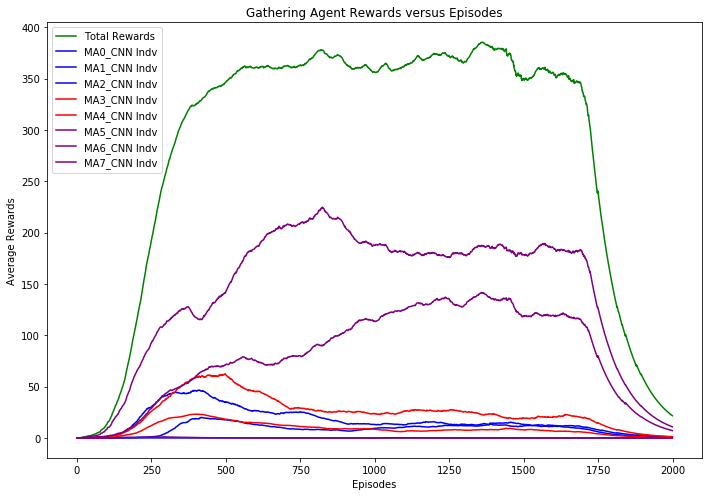

results/3T-8L1R/warlike/p-1.0_r0.005/
Max. Running Reward - MA0 Ind Reward: 32.067
Max. Running Reward - MA1 Ind Reward: 81.751
Max. Running Reward - MA2 Ind Reward: 34.039
Max. Running Reward - MA3 Ind Reward: 139.086
Max. Running Reward - MA4 Ind Reward: 41.759
Max. Running Reward - MA5 Ind Reward: 95.860
Max. Running Reward - MA6 Ind Reward: 84.038
Max. Running Reward - MA7 Ind Reward: 81.571
Max. Running Reward - All Agents: 438.464
Tribe 0 Sum Reward: 130.387
Tribe 1 Sum Reward: 175.630
Tribe 2 Sum Reward: 209.836




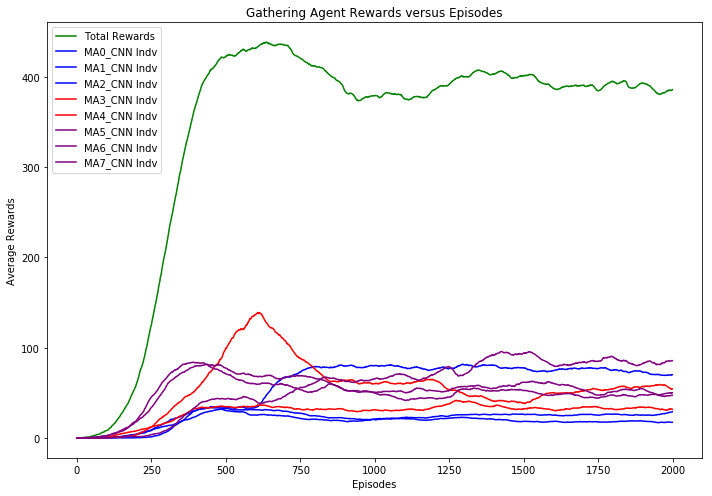

results/3T-8L1R/warlike/p-1.0_r0.01/
Max. Running Reward - MA0 Ind Reward: 51.959
Max. Running Reward - MA1 Ind Reward: 80.474
Max. Running Reward - MA2 Ind Reward: 92.932
Max. Running Reward - MA3 Ind Reward: 34.476
Max. Running Reward - MA4 Ind Reward: 88.443
Max. Running Reward - MA5 Ind Reward: 50.811
Max. Running Reward - MA6 Ind Reward: 138.940
Max. Running Reward - MA7 Ind Reward: 110.564
Max. Running Reward - All Agents: 435.487
Tribe 0 Sum Reward: 218.893
Tribe 1 Sum Reward: 104.773
Tribe 2 Sum Reward: 264.776




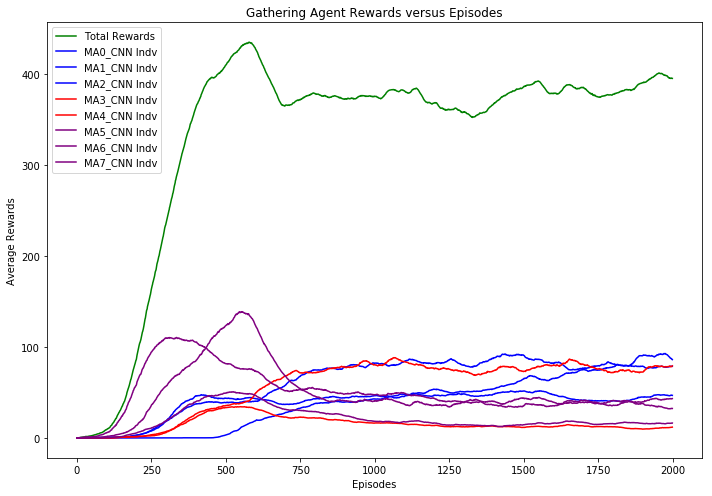

results/3T-8L1R/warlike/p-1.0_r0.05/
Max. Running Reward - MA0 Ind Reward: 42.596
Max. Running Reward - MA1 Ind Reward: 34.400
Max. Running Reward - MA2 Ind Reward: 30.286
Max. Running Reward - MA3 Ind Reward: 105.381
Max. Running Reward - MA4 Ind Reward: 170.497
Max. Running Reward - MA5 Ind Reward: 36.155
Max. Running Reward - MA6 Ind Reward: 81.332
Max. Running Reward - MA7 Ind Reward: 101.931
Max. Running Reward - All Agents: 439.957
Tribe 0 Sum Reward: 100.217
Tribe 1 Sum Reward: 210.910
Tribe 2 Sum Reward: 202.895




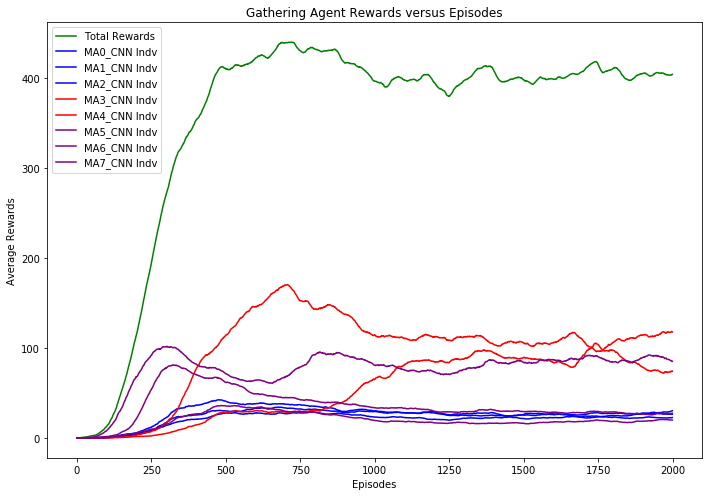

results/3T-8L1R/warlike/p-1.0_r0.1/
Max. Running Reward - MA0 Ind Reward: 40.015
Max. Running Reward - MA1 Ind Reward: 31.009
Max. Running Reward - MA2 Ind Reward: 91.506
Max. Running Reward - MA3 Ind Reward: 27.012
Max. Running Reward - MA4 Ind Reward: 101.251
Max. Running Reward - MA5 Ind Reward: 65.966
Max. Running Reward - MA6 Ind Reward: 27.843
Max. Running Reward - MA7 Ind Reward: 87.807
Max. Running Reward - All Agents: 374.727
Tribe 0 Sum Reward: 154.699
Tribe 1 Sum Reward: 107.617
Tribe 2 Sum Reward: 163.123




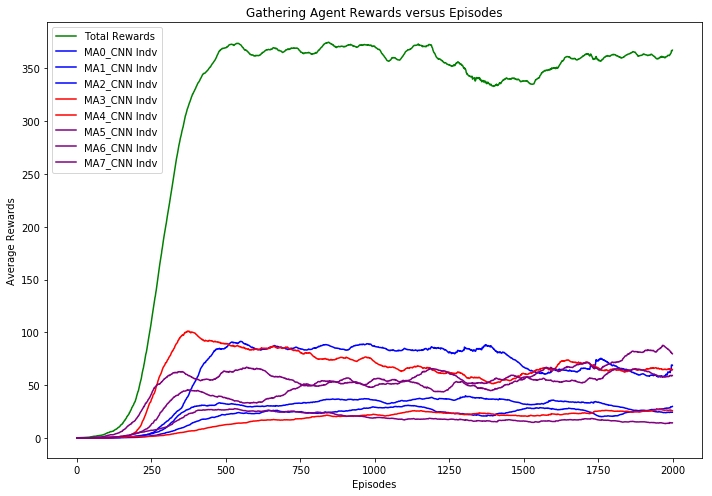

results/3T-8L1R/warlike/p-1.0_r0.5/
Max. Running Reward - MA0 Ind Reward: 0.391
Max. Running Reward - MA1 Ind Reward: 0.000
Max. Running Reward - MA2 Ind Reward: 0.000
Max. Running Reward - MA3 Ind Reward: 0.060
Max. Running Reward - MA4 Ind Reward: 0.050
Max. Running Reward - MA5 Ind Reward: 0.194
Max. Running Reward - MA6 Ind Reward: 0.110
Max. Running Reward - MA7 Ind Reward: 4.220
Max. Running Reward - All Agents: 4.737
Tribe 0 Sum Reward: 0.391
Tribe 1 Sum Reward: 0.081
Tribe 2 Sum Reward: 4.335




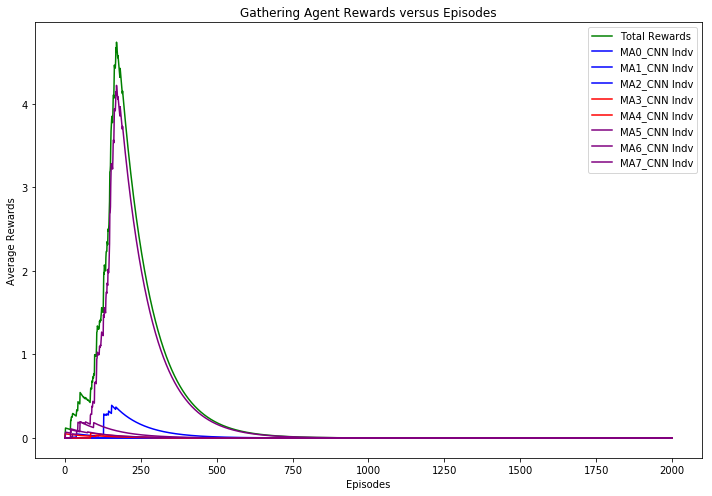

results/3T-8L1R/warlike/p-1.0_r1.0/
Max. Running Reward - MA0 Ind Reward: 0.010
Max. Running Reward - MA1 Ind Reward: 0.000
Max. Running Reward - MA2 Ind Reward: 0.000
Max. Running Reward - MA3 Ind Reward: 0.000
Max. Running Reward - MA4 Ind Reward: 0.010
Max. Running Reward - MA5 Ind Reward: 0.101
Max. Running Reward - MA6 Ind Reward: 0.136
Max. Running Reward - MA7 Ind Reward: 0.326
Max. Running Reward - All Agents: 0.525
Tribe 0 Sum Reward: 0.010
Tribe 1 Sum Reward: 0.010
Tribe 2 Sum Reward: 0.519




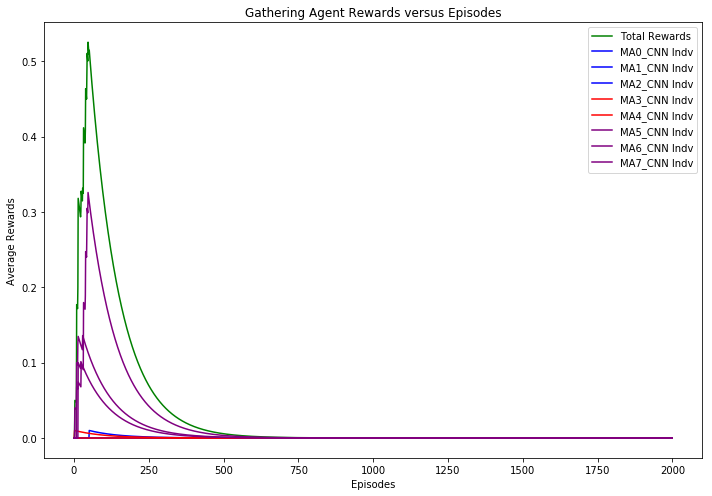

In [16]:
game = 'Gathering'

dir_names = ["results/3T-9L1R/warlike/p-1.0_r0.001/",
             "results/3T-9L1R/warlike/p-1.0_r0.005/",
             "results/3T-9L1R/warlike/p-1.0_r0.01/",
             "results/3T-9L1R/warlike/p-1.0_r0.05/", 
             "results/3T-9L1R/warlike/p-1.0_r0.1/",
             "results/3T-9L1R/warlike/p-1.0_r0.5/",
             "results/3T-9L1R/warlike/p-1.0_r1.0/"]

num_learners = 8
num_tribes = 3

# Cultural parameter search
culture = 'warlike'

# Establish tribal association

tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


# 9 agents in 4 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]

for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]
    tribe_data = [[] for i in range(num_tribes)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_Gather.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)

    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Max. Running Reward - MA{} Ind Reward: {:.3f}'.format(i, max(data[i])))

    
    print('Max. Running Reward - All Agents: {:.3f}'.format(max(total)))

    tribe_data[0] = [sum(x) for x in zip(data[0],data[1],data[2])]
    tribe_data[1] = [sum(x) for x in zip(data[3],data[4])]
    tribe_data[2] = [sum(x) for x in zip(data[5],data[6],data[7])]

    for i in range(num_tribes):
        print('Tribe {} Sum Reward: {:.3f}'.format(i, max(tribe_data[i])))
    
    print ('\n')

    plt.figure(figsize=(10, 7))
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('{} Agent Rewards versus Episodes'.format(game))
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Culture = Cooperative

Run finish_episode() specific to this culture.

In [6]:
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    total_norms = [0 for i in range(num_learners)]
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    T_reward = []

   
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        for t in tribes:
            if t.name is learners[i].tribe:
                T_reward = t.tribal_awards()
                
                # For debug only
                # print('Agent{} receives tribal award from Tribe{}'.format(i,t.name))
                # print (T_reward)
                # print (learners[i].rewards)
        
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # The agent is incentivized to cooperate by an award of 30% of what the tribe takes
            # in by all its members
            R = r + T + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norms[i] = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        
    # clear all agent's history only at the end of episode; they are needed for tribal reward calc
    for i in range(num_learners):
        learners[i].clear_history()


    return total_norms


In [7]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 9 learning agents, 0 trained agents, 1 random agents
num_learners = 9
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 5000
max_frames = 300
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 100
save_interval = 500

def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

# Cultural parameter search
cultures =[#{'name':'cooperative', 'coop_factor':50},
           #{'name':'cooperative', 'coop_factor':25},
           #{'name':'cooperative', 'coop_factor':20},
           {'name':'cooperative', 'coop_factor':15},
           #{'name':'cooperative', 'coop_factor':10},
           #{'name':'cooperative', 'coop_factor':5.0},
           #{'name':'cooperative', 'coop_factor':1.0},
           #{'name':'cooperative', 'coop_factor':0.1},
           #{'name':'cooperative', 'coop_factor':0.01}
          ]

for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
            """
            Disable for now! No trained model exist!!!
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-9L1R/'
                results_dir = 'results/3T-9L1R/'

                model_file = model_dir+'{}/cf{}/MA{}_{}__ep{}.p'.format(culture['name'], culture['coop_factor'],\
                                 i, game, ep+prior_eps+1)
                data_file = results_dir+'{}/cf{}/MA{}_{}.p'.format(culture['name'], culture['coop_factor'],\
                                                      i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Learner agent 8
Load random agent 9
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.03968
Learner:5	Reward total:0	Running mean: 0.0
Learner:6	Reward total:0	Running mean: 0.03869
Learner:7	Reward total:9	Running mean: 0.1914
Learner:8	Reward total:0	Running mean: 0.1604
Max Norms =  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '214.47', '112.64', '101.37']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:0	Running mean: 0.0258
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	

Max Norms =  ['73.17', '85.18', '103.88', '16.35', '40.84', '104.11', '28.78', '62.07', '76.73']
....................................................................................................
Episode 1400 complete
Learner:0	Reward total:0	Running mean: 0.001058
Learner:1	Reward total:21	Running mean: 10.6
Learner:2	Reward total:0	Running mean: 0.06725
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.01255
Learner:5	Reward total:15	Running mean: 37.7
Learner:6	Reward total:0	Running mean: 0.07153
Learner:7	Reward total:3	Running mean: 7.93
Learner:8	Reward total:50	Running mean: 25.29
Max Norms =  ['70.86', '35.88', '85.87', '27.13', '59.73', '66.91', '53.16', '60.67', '77.62']
....................................................................................................
Episode 1500 complete
Learner:0	Reward total:0	Running mean: 0.0003873
Learner:1	Reward total:19	Running mean: 11.49
Learner:2	Reward total:0	Running mean: 0.08845
Learner:

Max Norms =  ['20.71', '43.22', '22.66', '24.61', '52.85', '175.00', '54.31', '46.36', '51.70']
....................................................................................................
Episode 2700 complete
Learner:0	Reward total:0	Running mean: 9.374e-07
Learner:1	Reward total:43	Running mean: 21.38
Learner:2	Reward total:0	Running mean: 0.001113
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 2.657e-08
Learner:5	Reward total:12	Running mean: 24.73
Learner:6	Reward total:0	Running mean: 2.556e-06
Learner:7	Reward total:5	Running mean: 18.6
Learner:8	Reward total:13	Running mean: 31.56
Max Norms =  ['25.50', '87.89', '25.68', '37.25', '37.10', '77.43', '8.85', '18.45', '45.52']
....................................................................................................
Episode 2800 complete
Learner:0	Reward total:0	Running mean: 3.431e-07
Learner:1	Reward total:7	Running mean: 21.94
Learner:2	Reward total:0	Running mean: 0.0004074
L

Max Norms =  ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '13.42', '9.19', '73.47']
....................................................................................................
Episode 4000 complete
Learner:0	Reward total:0	Running mean: 1.985e-12
Learner:1	Reward total:17	Running mean: 10.43
Learner:2	Reward total:0	Running mean: 6.285e-07
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 5.625e-14
Learner:5	Reward total:28	Running mean: 30.0
Learner:6	Reward total:0	Running mean: 0.004672
Learner:7	Reward total:31	Running mean: 30.24
Learner:8	Reward total:29	Running mean: 47.46
Max Norms =  ['0.22', '113.28', '6.82', '15.66', '30.20', '65.84', '49.27', '28.65', '61.18']
....................................................................................................
Episode 4100 complete
Learner:0	Reward total:0	Running mean: 7.264e-13
Learner:1	Reward total:0	Running mean: 12.18
Learner:2	Reward total:0	Running mean: 2.301e-07
Learner:

Load AI agent 0
Load AI agent 1
Load AI agent 2
Load AI agent 3
Load AI agent 4
Load AI agent 5
Load AI agent 6
Load AI agent 7
Load AI agent 8
results/3T-9L1R/cooperative/cf0.01/
Max. Running Reward - MA0 Ind Reward: 0.021
Max. Running Reward - MA1 Ind Reward: 0.080
Max. Running Reward - MA2 Ind Reward: 42.505
Max. Running Reward - MA3 Ind Reward: 9.736
Max. Running Reward - MA4 Ind Reward: 14.503
Max. Running Reward - MA5 Ind Reward: 13.634
Max. Running Reward - MA6 Ind Reward: 10.882
Max. Running Reward - MA7 Ind Reward: 12.086
Max. Running Reward - MA8 Ind Reward: 44.873
Max. Running Reward - All Agents: 103.967
Tribe 0 Sum Reward: 42.505
Tribe 1 Sum Reward: 19.556
Tribe 2 Sum Reward: 33.421




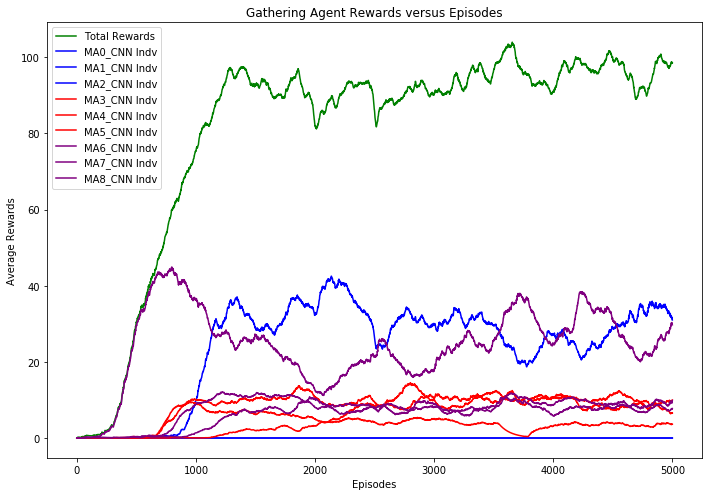

results/3T-9L1R/cooperative/cf0.1/
Max. Running Reward - MA0 Ind Reward: 0.135
Max. Running Reward - MA1 Ind Reward: 5.599
Max. Running Reward - MA2 Ind Reward: 0.556
Max. Running Reward - MA3 Ind Reward: 12.678
Max. Running Reward - MA4 Ind Reward: 0.211
Max. Running Reward - MA5 Ind Reward: 0.011
Max. Running Reward - MA6 Ind Reward: 0.216
Max. Running Reward - MA7 Ind Reward: 66.247
Max. Running Reward - MA8 Ind Reward: 79.403
Max. Running Reward - All Agents: 121.471
Tribe 0 Sum Reward: 5.738
Tribe 1 Sum Reward: 12.733
Tribe 2 Sum Reward: 66.251




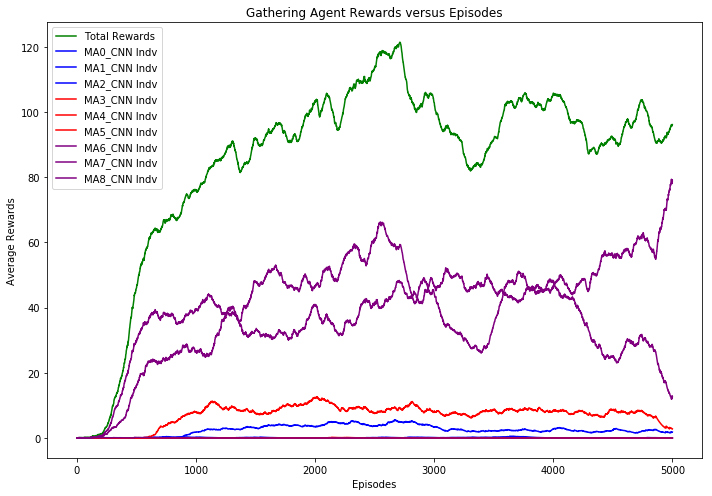

results/3T-9L1R/cooperative/cf1.0/
Max. Running Reward - MA0 Ind Reward: 0.065
Max. Running Reward - MA1 Ind Reward: 0.074
Max. Running Reward - MA2 Ind Reward: 14.319
Max. Running Reward - MA3 Ind Reward: 2.280
Max. Running Reward - MA4 Ind Reward: 1.975
Max. Running Reward - MA5 Ind Reward: 34.428
Max. Running Reward - MA6 Ind Reward: 0.495
Max. Running Reward - MA7 Ind Reward: 72.334
Max. Running Reward - MA8 Ind Reward: 35.759
Max. Running Reward - All Agents: 125.305
Tribe 0 Sum Reward: 14.319
Tribe 1 Sum Reward: 3.256
Tribe 2 Sum Reward: 83.149




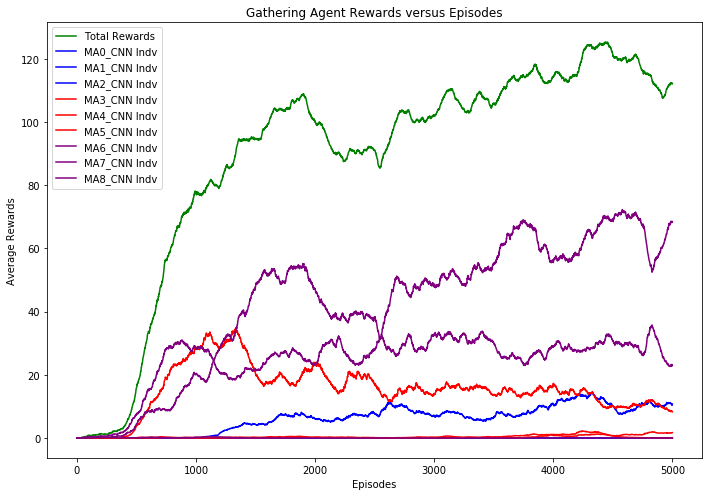

results/3T-9L1R/cooperative/cf5.0/
Max. Running Reward - MA0 Ind Reward: 22.284
Max. Running Reward - MA1 Ind Reward: 0.098
Max. Running Reward - MA2 Ind Reward: 0.030
Max. Running Reward - MA3 Ind Reward: 9.607
Max. Running Reward - MA4 Ind Reward: 88.451
Max. Running Reward - MA5 Ind Reward: 4.436
Max. Running Reward - MA6 Ind Reward: 44.492
Max. Running Reward - MA7 Ind Reward: 0.257
Max. Running Reward - MA8 Ind Reward: 93.253
Max. Running Reward - All Agents: 147.019
Tribe 0 Sum Reward: 22.286
Tribe 1 Sum Reward: 89.165
Tribe 2 Sum Reward: 44.708




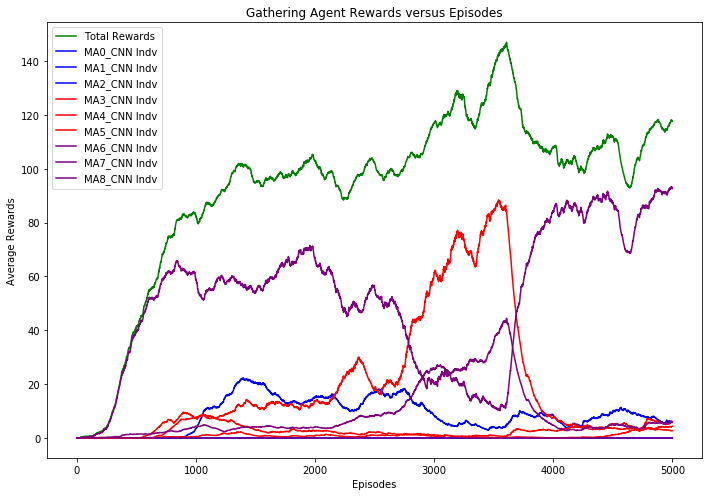

results/3T-9L1R/cooperative/cf10/
Max. Running Reward - MA0 Ind Reward: 26.527
Max. Running Reward - MA1 Ind Reward: 32.369
Max. Running Reward - MA2 Ind Reward: 0.892
Max. Running Reward - MA3 Ind Reward: 12.640
Max. Running Reward - MA4 Ind Reward: 0.346
Max. Running Reward - MA5 Ind Reward: 44.378
Max. Running Reward - MA6 Ind Reward: 37.434
Max. Running Reward - MA7 Ind Reward: 0.402
Max. Running Reward - MA8 Ind Reward: 35.232
Max. Running Reward - All Agents: 121.518
Tribe 0 Sum Reward: 50.397
Tribe 1 Sum Reward: 12.750
Tribe 2 Sum Reward: 72.142




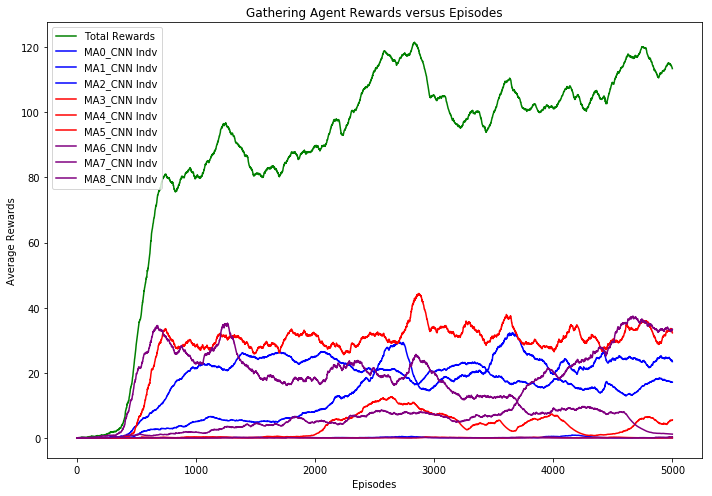

results/3T-9L1R/cooperative/cf15/
Max. Running Reward - MA0 Ind Reward: 0.226
Max. Running Reward - MA1 Ind Reward: 23.934
Max. Running Reward - MA2 Ind Reward: 0.120
Max. Running Reward - MA3 Ind Reward: 0.000
Max. Running Reward - MA4 Ind Reward: 0.180
Max. Running Reward - MA5 Ind Reward: 40.965
Max. Running Reward - MA6 Ind Reward: 0.288
Max. Running Reward - MA7 Ind Reward: 54.650
Max. Running Reward - MA8 Ind Reward: 81.527
Max. Running Reward - All Agents: 138.482
Tribe 0 Sum Reward: 23.941
Tribe 1 Sum Reward: 0.180
Tribe 2 Sum Reward: 67.793




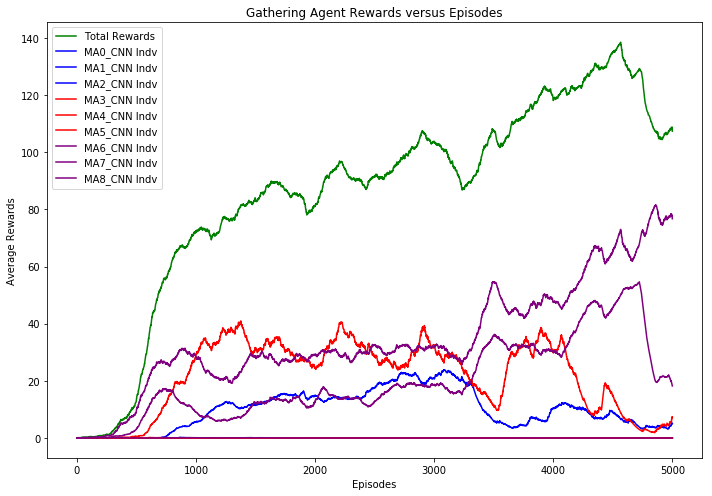

results/3T-9L1R/cooperative/cf20/
Max. Running Reward - MA0 Ind Reward: 0.040
Max. Running Reward - MA1 Ind Reward: 69.063
Max. Running Reward - MA2 Ind Reward: 0.356
Max. Running Reward - MA3 Ind Reward: 0.230
Max. Running Reward - MA4 Ind Reward: 12.064
Max. Running Reward - MA5 Ind Reward: 13.737
Max. Running Reward - MA6 Ind Reward: 0.498
Max. Running Reward - MA7 Ind Reward: 0.789
Max. Running Reward - MA8 Ind Reward: 57.833
Max. Running Reward - All Agents: 121.744
Tribe 0 Sum Reward: 69.063
Tribe 1 Sum Reward: 12.107
Tribe 2 Sum Reward: 14.158




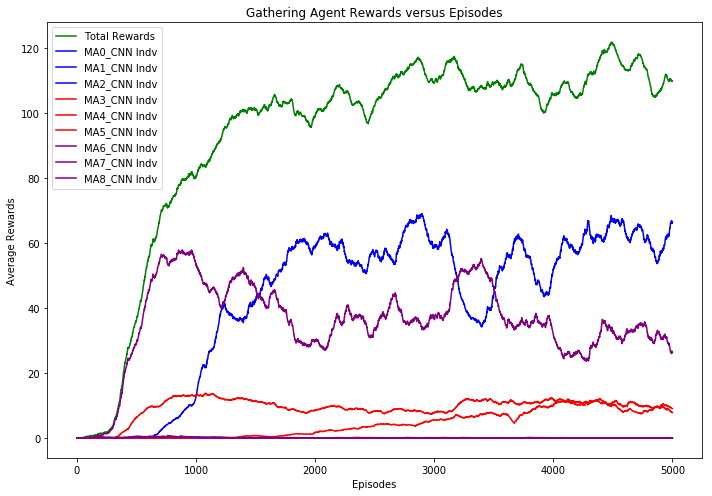

results/3T-9L1R/cooperative/cf25/
Max. Running Reward - MA0 Ind Reward: 146.346
Max. Running Reward - MA1 Ind Reward: 0.136
Max. Running Reward - MA2 Ind Reward: 0.225
Max. Running Reward - MA3 Ind Reward: 0.050
Max. Running Reward - MA4 Ind Reward: 12.939
Max. Running Reward - MA5 Ind Reward: 13.924
Max. Running Reward - MA6 Ind Reward: 0.443
Max. Running Reward - MA7 Ind Reward: 2.357
Max. Running Reward - MA8 Ind Reward: 62.920
Max. Running Reward - All Agents: 154.665
Tribe 0 Sum Reward: 146.369
Tribe 1 Sum Reward: 12.939
Tribe 2 Sum Reward: 14.292




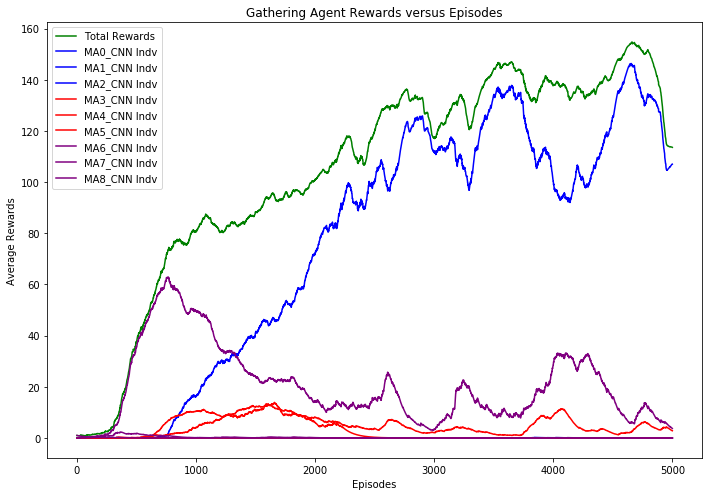

results/3T-9L1R/cooperative/cf50/
Max. Running Reward - MA0 Ind Reward: 0.218
Max. Running Reward - MA1 Ind Reward: 32.482
Max. Running Reward - MA2 Ind Reward: 19.504
Max. Running Reward - MA3 Ind Reward: 0.296
Max. Running Reward - MA4 Ind Reward: 0.270
Max. Running Reward - MA5 Ind Reward: 71.136
Max. Running Reward - MA6 Ind Reward: 0.340
Max. Running Reward - MA7 Ind Reward: 0.504
Max. Running Reward - MA8 Ind Reward: 45.578
Max. Running Reward - All Agents: 126.402
Tribe 0 Sum Reward: 48.262
Tribe 1 Sum Reward: 0.403
Tribe 2 Sum Reward: 71.138




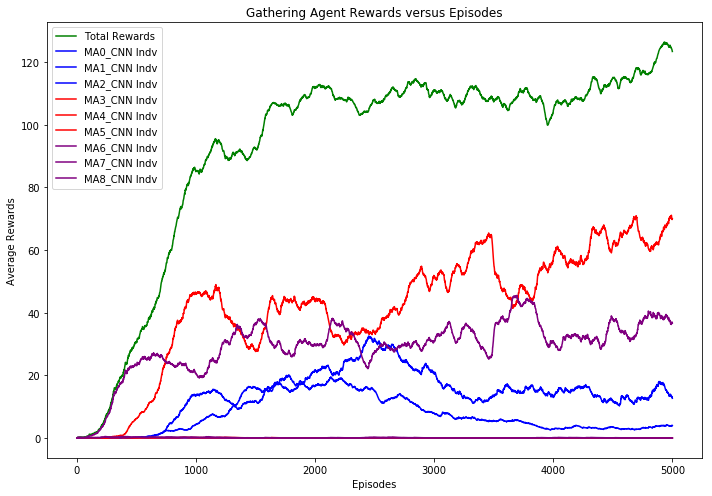

In [8]:
game = 'Gathering'

dir_names = ["results/3T-9L1R/cooperative/cf0.01/",
             "results/3T-9L1R/cooperative/cf0.1/",
             "results/3T-9L1R/cooperative/cf1.0/",
             "results/3T-9L1R/cooperative/cf5.0/",
             "results/3T-9L1R/cooperative/cf10/",
             "results/3T-9L1R/cooperative/cf15/",
             "results/3T-9L1R/cooperative/cf20/",
             "results/3T-9L1R/cooperative/cf25/",
             "results/3T-9L1R/cooperative/cf50/"]

num_learners = 9
num_tribes = 3

# Cultural parameter search
culture = 'cooperative'

agents = []
for i in range(num_learners):
    print("Load AI agent {}".format(i))
    agents.append(Policy(4, 8, i))

agents.append(Rdn_Policy())

# Establish tribal association

tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!

# 9 agents in 4 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]


for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]
    tribe_data = [[] for i in range(num_tribes)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_Gather.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)

    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Max. Running Reward - MA{} Ind Reward: {:.3f}'.format(i, max(data[i])))

    
    print('Max. Running Reward - All Agents: {:.3f}'.format(max(total)))

    tribe_data[0] = [sum(x) for x in zip(data[0],data[1],data[2])]
    tribe_data[1] = [sum(x) for x in zip(data[3],data[4])]
    tribe_data[2] = [sum(x) for x in zip(data[5],data[6],data[7])]

    for i in range(num_tribes):
        print('Tribe {} Sum Reward: {:.3f}'.format(i, max(tribe_data[i])))
    
    print ('\n')

    plt.figure(figsize=(10, 7))
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('{} Agent Rewards versus Episodes'.format(game))
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Cooperative - Trained to 10000ep 

In [ ]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 9 learning agents, 0 trained agents, 1 random agents
num_learners = 9
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 10000
max_frames = 300
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 200
save_interval = 500

def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

# Cultural parameter search
cultures =[
           #{'name':'cooperative', 'coop_factor':25},
           #{'name':'cooperative', 'coop_factor':30},
           {'name':'cooperative', 'coop_factor':15},
           {'name':'cooperative', 'coop_factor':20}
          ]

for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
            """
            Disable for now! No trained model exist!!!
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-9L1R/'
                results_dir = 'results/3T-9L1R/'

                model_file = model_dir+'{}-10000ep/cf{}/MA{}_{}__ep{}.p'.format(culture['name'], culture['coop_factor'],\
                                 i, game, ep+prior_eps+1)
                data_file = results_dir+'{}-10000ep/cf{}/MA{}_{}.p'.format(culture['name'], culture['coop_factor'],\
                                                      i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

## Culture = No Fragging

Run finish_episode() specific to this culture.

In [68]:
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    total_norms = [0 for i in range(num_learners)]
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    T_reward = []

   
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        for t in tribes:
            if t.name is learners[i].tribe:
                T_reward = t.tribal_awards(US_hits = learners[i].US_hits)
       
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # The agent is incentivized to cooperate by an award of 30% of what the tribe takes
            # in by all its members
            R = r + T + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norms[i] = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        learners[i].clear_history()   # clear an agent's history at the end of episode


    return total_norms

In [69]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 9 learning agents, 0 trained agents, 1 random agents
num_learners = 9
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 5000
max_frames = 300
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 100
save_interval = 500

def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

# Cultural parameter search
cultures =[#{'name':'no_fragging', 'penalty':-0.01},
           #{'name':'no_fragging', 'penalty':-0.1},
           #{'name':'no_fragging', 'penalty':-1.0},
           #{'name':'no_fragging', 'penalty':-10.0},
           {'name':'no_fragging', 'penalty':-100.0}
          ]

for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
            """
            Disable for now! No trained model exist!!!
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!



    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-9L1R/'
                results_dir = 'results/3T-9L1R/'

                model_file = model_dir+'{}/p{}/MA{}_{}__ep{}.p'.format(culture['name'], culture['penalty'],\
                                 i, game, ep+prior_eps+1)
                data_file = results_dir+'{}/p{}/MA{}_{}.p'.format(culture['name'], culture['penalty'],\
                                                      i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Load random agent 8
....................................................................................................
Episode 100 complete
Learner:0	Reward total:0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mean: 0.01379
Learner:4	Reward total:0	Running mean: 0.01083
Learner:5	Reward total:0	Running mean: 0.05354
Learner:6	Reward total:0	Running mean: 0.1491
Learner:7	Reward total:0	Running mean: 0.2374
Max Norms =  ['0.00', '0.00', '0.00', '0.00', '0.00', '230.45', '78.84', '0.00']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:0	Running mean: 0.0
Learner:1	Reward total:0	Running mean: 0.0
Learner:2	Reward total:0	Running mean: 0.0
Learner:3	Reward total:0	Running mea

....................................................................................................
Episode 900 complete
Learner:0	Reward total:14	Running mean: 8.763
Learner:1	Reward total:16	Running mean: 16.65
Learner:2	Reward total:4	Running mean: 0.8184
Learner:3	Reward total:0	Running mean: 9.195
Learner:4	Reward total:5	Running mean: 19.85
Learner:5	Reward total:36	Running mean: 30.76
Learner:6	Reward total:21	Running mean: 24.19
Learner:7	Reward total:17	Running mean: 24.7
Max Norms =  ['37.47', '59.82', '91.08', '0.00', '43.96', '100.75', '166.32', '130.34']
....................................................................................................
Episode 1000 complete
Learner:0	Reward total:3	Running mean: 7.295
Learner:1	Reward total:7	Running mean: 14.03
Learner:2	Reward total:5	Running mean: 3.623
Learner:3	Reward total:0	Running mean: 6.953
Learner:4	Reward total:12	Running mean: 16.15
Learner:5	Reward total:3	Running mean: 25.08
Learner:6	Reward total:5	Runnin

....................................................................................................
Episode 300 complete
Learner:0	Reward total:2	Running mean: 0.5549
Learner:1	Reward total:5	Running mean: 3.394
Learner:2	Reward total:1	Running mean: 1.045
Learner:3	Reward total:0	Running mean: 1.546
Learner:4	Reward total:4	Running mean: 2.057
Learner:5	Reward total:0	Running mean: 0.7854
Learner:6	Reward total:1	Running mean: 2.034
Learner:7	Reward total:48	Running mean: 18.7
Max Norms =  ['119.38', '125.12', '128.07', '0.00', '91.93', '0.00', '172.45', '146.38']
....................................................................................................
Episode 400 complete
Learner:0	Reward total:1	Running mean: 2.172
Learner:1	Reward total:8	Running mean: 5.893
Learner:2	Reward total:0	Running mean: 2.015
Learner:3	Reward total:9	Running mean: 6.294
Learner:4	Reward total:18	Running mean: 7.327
Learner:5	Reward total:10	Running mean: 2.261
Learner:6	Reward total:23	Running

Max Norms =  ['89.44', '72.66', '131.57', '104.81', '131.32', '103.82', '165.68', '74.59']
....................................................................................................
Episode 1800 complete
Learner:0	Reward total:7	Running mean: 10.67
Learner:1	Reward total:20	Running mean: 13.87
Learner:2	Reward total:12	Running mean: 10.16
Learner:3	Reward total:66	Running mean: 51.91
Learner:4	Reward total:9	Running mean: 20.58
Learner:5	Reward total:14	Running mean: 14.41
Learner:6	Reward total:6	Running mean: 9.853
Learner:7	Reward total:23	Running mean: 15.73
Max Norms =  ['98.87', '101.20', '108.78', '105.92', '119.64', '24.94', '111.71', '107.25']
....................................................................................................
Episode 1900 complete
Learner:0	Reward total:5	Running mean: 11.45
Learner:1	Reward total:7	Running mean: 13.45
Learner:2	Reward total:11	Running mean: 8.888
Learner:3	Reward total:39	Running mean: 52.68
Learner:4	Reward total:4

Max Norms =  ['0.00', '69.30', '0.00', '104.90', '45.40', '112.61', '188.58', '54.62']
....................................................................................................
Episode 1200 complete
Learner:0	Reward total:2	Running mean: 8.493
Learner:1	Reward total:7	Running mean: 24.12
Learner:2	Reward total:0	Running mean: 0.0053
Learner:3	Reward total:20	Running mean: 24.4
Learner:4	Reward total:22	Running mean: 13.97
Learner:5	Reward total:29	Running mean: 24.94
Learner:6	Reward total:33	Running mean: 25.52
Learner:7	Reward total:22	Running mean: 23.94
Max Norms =  ['77.99', '93.89', '0.00', '78.64', '67.35', '103.30', '120.42', '26.15']
....................................................................................................
Episode 1300 complete
Learner:0	Reward total:9	Running mean: 12.69
Learner:1	Reward total:21	Running mean: 24.59
Learner:2	Reward total:0	Running mean: 0.02698
Learner:3	Reward total:33	Running mean: 23.45
Learner:4	Reward total:11	Runni

Max Norms =  ['108.78', '85.71', '116.13', '125.00', '113.89', '143.01', '112.85', '115.93']
....................................................................................................
Episode 600 complete
Learner:0	Reward total:34	Running mean: 16.47
Learner:1	Reward total:14	Running mean: 14.78
Learner:2	Reward total:21	Running mean: 11.22
Learner:3	Reward total:4	Running mean: 10.59
Learner:4	Reward total:7	Running mean: 8.561
Learner:5	Reward total:15	Running mean: 19.46
Learner:6	Reward total:13	Running mean: 18.53
Learner:7	Reward total:27	Running mean: 23.17
Max Norms =  ['143.93', '98.90', '114.25', '84.79', '57.74', '79.15', '70.65', '108.62']
....................................................................................................
Episode 700 complete
Learner:0	Reward total:27	Running mean: 18.73
Learner:1	Reward total:18	Running mean: 17.62
Learner:2	Reward total:13	Running mean: 15.19
Learner:3	Reward total:10	Running mean: 13.03
Learner:4	Reward total:2

results/3T-8L1R/no_fragging/p-0.01/
Max. Running Reward - MA0 Ind Reward: 0.000
Max. Running Reward - MA1 Ind Reward: 12.885
Max. Running Reward - MA2 Ind Reward: 11.714
Max. Running Reward - MA3 Ind Reward: 32.669
Max. Running Reward - MA4 Ind Reward: 43.765
Max. Running Reward - MA5 Ind Reward: 20.150
Max. Running Reward - MA6 Ind Reward: 14.822
Max. Running Reward - MA7 Ind Reward: 32.682
Max. Running Reward - All Agents: 129.518
Tribe 0 Sum Reward: 20.735
Tribe 1 Sum Reward: 67.540
Tribe 2 Sum Reward: 66.905




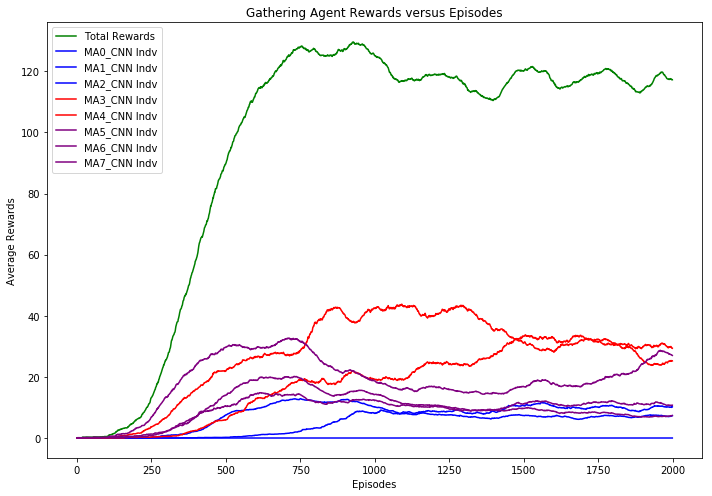

results/3T-8L1R/no_fragging/p-0.1/
Max. Running Reward - MA0 Ind Reward: 9.069
Max. Running Reward - MA1 Ind Reward: 22.152
Max. Running Reward - MA2 Ind Reward: 11.765
Max. Running Reward - MA3 Ind Reward: 9.991
Max. Running Reward - MA4 Ind Reward: 26.864
Max. Running Reward - MA5 Ind Reward: 36.046
Max. Running Reward - MA6 Ind Reward: 31.743
Max. Running Reward - MA7 Ind Reward: 47.510
Max. Running Reward - All Agents: 145.194
Tribe 0 Sum Reward: 30.604
Tribe 1 Sum Reward: 35.475
Tribe 2 Sum Reward: 86.685




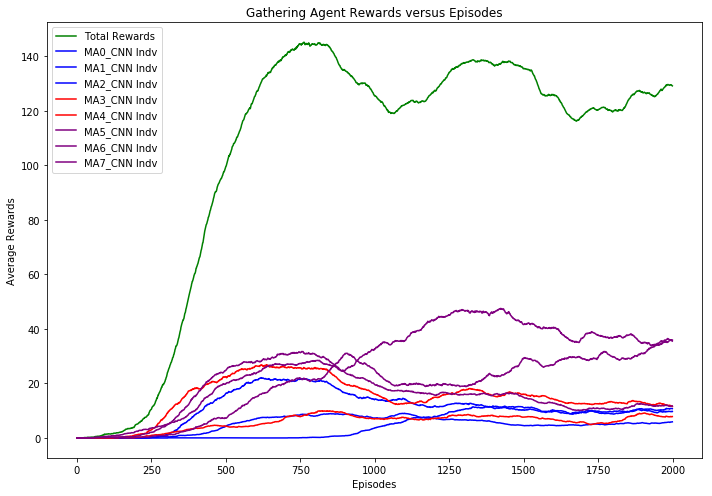

results/3T-8L1R/no_fragging/p-1.0/
Max. Running Reward - MA0 Ind Reward: 15.849
Max. Running Reward - MA1 Ind Reward: 17.207
Max. Running Reward - MA2 Ind Reward: 14.387
Max. Running Reward - MA3 Ind Reward: 74.504
Max. Running Reward - MA4 Ind Reward: 22.764
Max. Running Reward - MA5 Ind Reward: 16.096
Max. Running Reward - MA6 Ind Reward: 21.407
Max. Running Reward - MA7 Ind Reward: 36.736
Max. Running Reward - All Agents: 150.716
Tribe 0 Sum Reward: 46.427
Tribe 1 Sum Reward: 81.571
Tribe 2 Sum Reward: 65.017




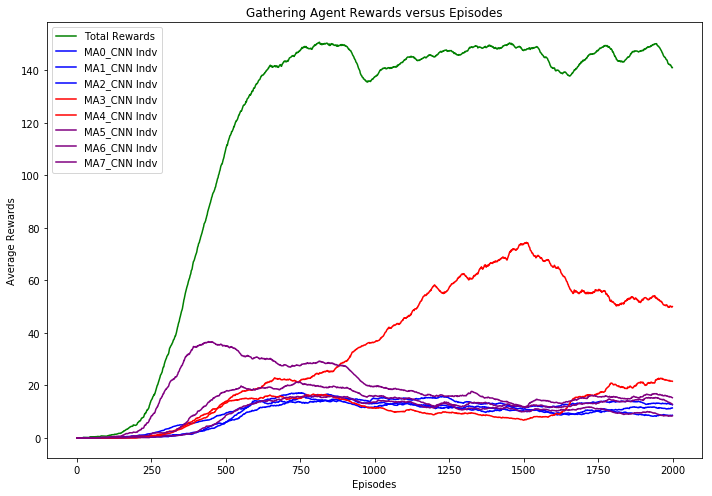

results/3T-8L1R/no_fragging/p-10.0/
Max. Running Reward - MA0 Ind Reward: 18.364
Max. Running Reward - MA1 Ind Reward: 28.363
Max. Running Reward - MA2 Ind Reward: 0.085
Max. Running Reward - MA3 Ind Reward: 24.844
Max. Running Reward - MA4 Ind Reward: 16.247
Max. Running Reward - MA5 Ind Reward: 25.996
Max. Running Reward - MA6 Ind Reward: 28.398
Max. Running Reward - MA7 Ind Reward: 34.021
Max. Running Reward - All Agents: 149.477
Tribe 0 Sum Reward: 43.922
Tribe 1 Sum Reward: 38.988
Tribe 2 Sum Reward: 76.884




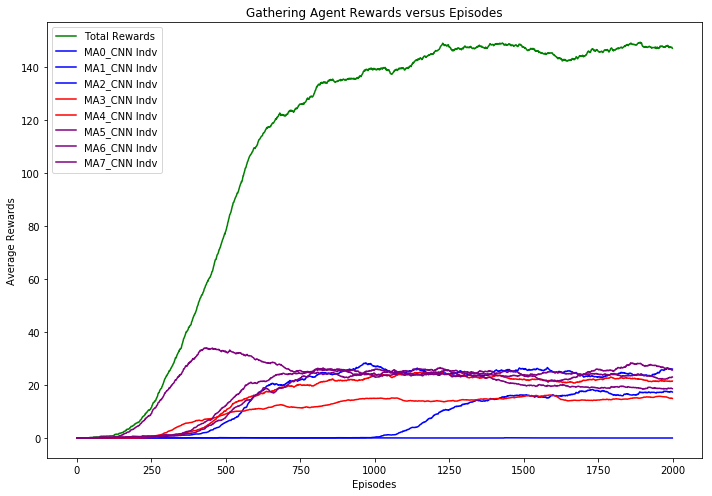

results/3T-8L1R/no_fragging/p-100.0/
Max. Running Reward - MA0 Ind Reward: 23.472
Max. Running Reward - MA1 Ind Reward: 22.041
Max. Running Reward - MA2 Ind Reward: 20.151
Max. Running Reward - MA3 Ind Reward: 20.834
Max. Running Reward - MA4 Ind Reward: 16.808
Max. Running Reward - MA5 Ind Reward: 21.371
Max. Running Reward - MA6 Ind Reward: 22.825
Max. Running Reward - MA7 Ind Reward: 29.591
Max. Running Reward - All Agents: 163.937
Tribe 0 Sum Reward: 62.714
Tribe 1 Sum Reward: 36.529
Tribe 2 Sum Reward: 67.425




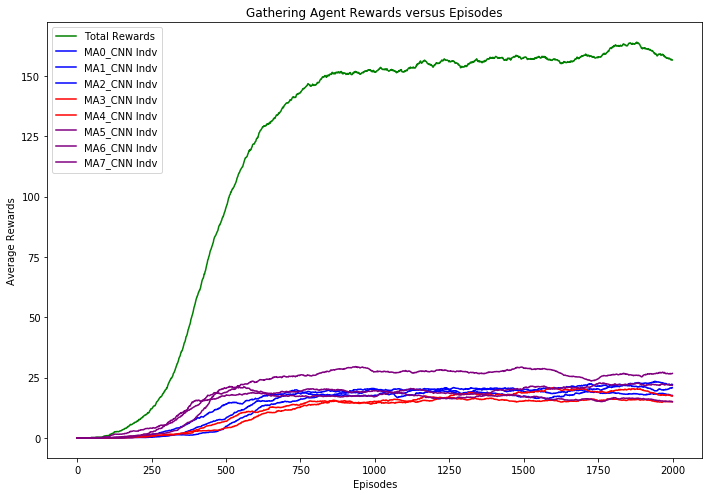

In [13]:
game = 'Gathering'

dir_names = ["results/3T-9L1R/no_fragging/p-0.01/",
             "results/3T-9L1R/no_fragging/p-0.1/", 
             "results/3T-9L1R/no_fragging/p-1.0/",
             "results/3T-9L1R/no_fragging/p-10.0/",
             "results/3T-9L1R/no_fragging/p-100.0/"]

num_learners = 9
num_tribes = 3

# Cultural parameter search
culture = 'no_fragging'

agents = []
for i in range(num_learners):
    print("Load AI agent {}".format(i))
    agents.append(Policy(4, 8, i))

agents.append(Rdn_Policy())

# Establish tribal association

tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


# 9 agents in 4 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]


for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]
    tribe_data = [[] for i in range(num_tribes)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_Gather.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)

    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Max. Running Reward - MA{} Ind Reward: {:.3f}'.format(i, max(data[i])))

    
    print('Max. Running Reward - All Agents: {:.3f}'.format(max(total)))

    tribe_data[0] = [sum(x) for x in zip(data[0],data[1],data[2])]
    tribe_data[1] = [sum(x) for x in zip(data[3],data[4])]
    tribe_data[2] = [sum(x) for x in zip(data[5],data[6],data[7])]

    for i in range(num_tribes):
        print('Tribe {} Sum Reward: {:.3f}'.format(i, max(tribe_data[i])))
    
    print ('\n')

    plt.figure(figsize=(10, 7))
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('{} Agent Rewards versus Episodes'.format(game))
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Culture = Pacifist

Run finish_episode() specific to this culture.

In [79]:
def finish_episode(learners, optimizers, gamma, cuda):
    """ 
    Note that in RL, policy gradient is calculated at the end of an episode and only then used to 
    update the weights of an agent's policy. This is very different compared to image recog.
    
    The code will perform policy update on each learning agent independently. Reward for each time 
    step is stored in the list policy.rewards[] --> r(t)
    """  
    
    num_learners = len(learners)
    total_norms = [0 for i in range(num_learners)]
    policy_losses = [[] for i in range(num_learners)]
    losses = [[] for i in range(num_learners)]
    T_reward = []

   
    for i in range(num_learners):

        R = 0
        saved_actions = learners[i].saved_actions
        
        for t in tribes:
            if t.name is learners[i].tribe:
                T_reward = t.tribal_awards(tag_hist = learners[i].tag_hist)
 
                # For debug only
                # print('Agent{} receives tribal award from Tribe{}'.format(i,t.name))
                # print (T_reward)
                # print (learners[i].rewards)
                
        # Do not implement actor-critic for now
        # value_losses = []
        
        rewards = deque()

        for r,T in zip(learners[i].rewards[::-1],T_reward[::-1]):
            # The agent is incentivized to cooperate by an award of 30% of what the tribe takes
            # in by all its members
            R = r + T + gamma * R
            rewards.appendleft(R)
            
        rewards = list(rewards)
        rewards = torch.Tensor(rewards)
        if cuda:
            rewards = rewards.cuda()

        # z-score rewards
        rewards = (rewards - rewards.mean()) / (1.1e-7+rewards.std())
        
        #Debug     
        #print (rewards)       
        
        """
        Do not implement actor-critic for now!!!
        for (log_prob, state_value), r in zip(saved_actions, rewards):
            reward = r - state_value.data[0]
            policy_losses.append(-log_prob * Variable(reward))
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            value_losses.append(torch.nn.functional.smooth_l1_loss(state_value,
                                                               Variable(r)))

        optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()        
        
        
        """
        for log_prob, r in zip(saved_actions, rewards):
            r = torch.Tensor([r])
            if cuda:
                r = r.cuda()
            policy_losses[i].append(-log_prob * Variable(r))

        optimizers[i].zero_grad()
        losses[i] = torch.stack(policy_losses[i]).sum()
        losses[i].backward()
        
        # Gradient Clipping Update: prevent exploding gradient
        total_norms[i] = torch.nn.utils.clip_grad_norm_(learners[i].parameters(), 8000)
        
        optimizers[i].step()
        learners[i].clear_history()   # clear an agent's history at the end of episode


    return total_norms

In [80]:
import gym
import sys
import pickle
from collections import deque

import torch
import torch.optim as optim
from torch.autograd import Variable
import numpy as np

# Initialize agents parameters
#   10 agents - 9 learning agents, 0 trained agents, 1 random agents
num_learners = 9
num_trained = 0
num_rdn = 1
num_statics = num_trained + num_rdn
num_agents = num_learners + num_statics  

# Initialize environment
game = "Gather"
num_actions = 8                       # 8 actions in Gathering

# Initialize training parameters
warm_start = False
num_frames = 4      # environ observation consists of a list of 4 stacked frames per agent
max_episodes = 5000
max_frames = 300
max_frames_ep = 0   # track highest number of frames an episode can last

# These trainer parameters works for Atari Breakout
gamma = 0.99  
lr = 1e-3
temp_start = 1.8  # Temperature for explore/exploit
temp_end = 1.0
log_interval = 100
save_interval = 500

def unpack_env_obs(env_obs):
    """
    Gathering is a partially-observable Markov Game. env_obs returned by GatheringEnv is a numpy 
    array of dimension (num_agent, 800), which represents the agents' observations of the game.

    The 800 elements (view_box) encodes 4 layers of 10x20 pixels frames in the format:
    (viewbox_width, viewbox_depth, 4).
    
    This code reshapes the above into stacked frames that can be accepted by the Policy class:
    (batch_idx, in_channel, width, height)
    
    """
    
    num_agents = len(env_obs)  # environ observations is a list of agents' observations
    
    obs = []
    for i in range(num_agents):
        x = env_obs[i]   # take the indexed agent's observation
        x = torch.Tensor(x)   # Convert to tensor
        
        # Policy is a 3-layer CNN
        x = x.view(1, 10, 20, -1)  # reshape into environment defined stacked frames
        x = x.permute(0, 3, 1, 2)  # permute to Policy accepted stacked frames
        obs.append(x)
        
    return obs  # return a list of Tensors


"""
For now, we do not implement LSTM            
# LSTM Change: Need to cycle hx and cx thru function
def select_action(model, state, lstm_hc, cuda):
    hx , cx = lstm_hc 
    num_frames, height, width = state.shape
    state = torch.FloatTensor(state.reshape(-1, num_frames, height, width))

    if cuda:
        state = state.cuda()

    probs, value, (hx, cx) = model((Variable(state), (hx, cx)))

    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)
    # LSTM Change: Need to cycle hx and cx thru function
    return action.data[0], log_prob, value, (hx, cx)
"""


def select_learner_action(model, obs, cuda):
    """
    This code expects obs to be an array of stacked frames of the following dim:
    (batch_idx, in_channel, width, height)
    
    This is inputted into model - the agent's Policy, which outputs a probability 
    distribution over available actions.
    
    Policy gradient is implemented using torch.distributions.Categorical. 
    """
    
    # Policy is a 3-layer CNN
    # _, num_frames, width, height = obs.shape
    # obs = torch.FloatTensor(obs.reshape(-1, num_frames, width, height))
    
    # Policy is a 2-layer NN for now
    # obs = obs.view(1, -1)
   
    if cuda:
        obs = obs.cuda()
      
    probs = model(obs)
    m = torch.distributions.Categorical(probs)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action.item(), log_prob 


def load_info(agents, narrate=False):
    for i in range(num_agents):    
        agents[i].load_info(info[i])
        if narrate:
            if agents[i].tagged:
                print('frame {}, agent{} is tagged'.format(frame,i))
            if agents[i].laser_fired:
                print('frame {}, agent{} fires its laser'.format(frame,i))
                print('and hit {} US and {} THEM'.format(agents[i].US_hit, agents[i].THEM_hit))
    return


# The main code starts here!!!

# Cultural parameter search
cultures =[
           # {'name':'pacifist', 'penalty':-0.01},
           # {'name':'pacifist', 'penalty':-0.1},
           # {'name':'pacifist', 'penalty':-1.0},
           # {'name':'pacifist', 'penalty':-10.0},
           {'name':'pacifist', 'penalty':-100.0}
          ]

for culture in cultures:   # Go down the list of cultures

    # Data structure for agents
    agents = []
    actions = []
    log_probs = []
    tags = []
    rewards = []
    optimizers = []

    # Cold start
    if warm_start is False:
   
        # Initialize learner agents, then load static agents (trained followed by random)
        for i in range(num_learners):
            print("Learner agent {}".format(i))
            agents.append(Policy(num_frames, num_actions, i)) # No weights loaded for learning agent
            optimizers.append(optim.Adam(agents[i].parameters(), lr=lr))
        
            # set up optimizer - this works for Atari Breakout
            # optimizers.append(optim.RMSprop(agents[i].parameters(), lr=lr, weight_decay=0.1)) 
        
        for i in range(num_learners, num_learners+num_trained):
            print ("No trained agent exist yet!")
            raise
            """
            Disable for now! No trained model exist!!!
            agents.append(Policy(num_frames, num_actions, i))
            agents[i].load_weights()         # load weight for static agent        
            """
        for i in range(num_learners+num_trained, num_agents):
            print("Load random agent {}".format(i))
            agents.append(Rdn_Policy())

    
        # Initialize all agent data
        actions = [0 for i in range(num_agents)]
        log_probs = [0 for i in range(num_agents)]
        tags = [0 for i in range(num_agents)]
        rewards = [0 for i in range(num_agents)]

        # Keep track of rewards learned by learners
        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
        running_reward = [None for i in range(num_learners)]   # running average
        running_rewards = [[] for i in range(num_learners)]   # history of running averages
        best_reward = [0 for i in range(num_learners)]    # best running average (for storing best_model)

        # This is to support warm start for training
        prior_eps = 0

    # Warm start
    if warm_start:
        print ("Cannot warm start")
        raise
    
        """
        # Disable for now!  Need to ensure model can support training on GPU and game playing
        # on both CPU and GPU.
    
        data_file = 'results/{}.p'.format(game)

        try:
            with open(data_file, 'rb') as f:
                running_rewards = pickle.load(f)
                running_reward = running_rewards[-1]

            prior_eps = len(running_rewards)

            model_file = 'saved_models/actor_critic_{}_ep_{}.p'.format(game, prior_eps)
            with open(model_file, 'rb') as f:
                # Model Save and Load Update: Include both model and optim parameters
                saved_model = pickle.load(f)
                model, optimizer = saved_model

        except OSError:
            print('Saved file not found. Creating new cold start model.')
            model = Policy(input_channels=num_frames, num_actions=num_actions)
            optimizer = optim.RMSprop(model.parameters(), lr=lr,
                                      weight_decay=0.1)
            running_rewards = []
            prior_eps = 0
        """

    # Establish tribal association

    tribes = []
    tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
    tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
    tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
    tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!

    # 9 agents in 4 tribes, used map defined in default.txt
    agent_colors = [agent.color for agent in agents]
    agent_tribes = [agent.tribe for agent in agents]
    env = GatheringEnv(n_agents=num_agents,agent_colors=agent_colors, agent_tribes=agent_tribes, \
                       map_name='default')    
   
    
    cuda = torch.cuda.is_available()

    if cuda:
        for i in range(num_learners):    # Learning agents need to utilize GPU
            agents[i].cuda()

        
    for ep in range(max_episodes):
    
        print('.', end='')  # To show progress
    
        # Anneal temperature from temp_start to temp_end
        for i in range(num_learners):    # For learning agents
            agents[i].temperature = max(temp_end, temp_start - (temp_start - temp_end) * (ep / max_episodes))

        env_obs = env.reset()  # Env return observations

        # For Debug only
        # print (len(env_obs))
        # print (env_obs[0].shape)
    
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)

        for i in range(num_learners):    # Reset agent info - laser tag statistics
            agents[i].reset_info()   

        # For Debug only
        # print (len(agents_obs))
        # print (agents_obs[0].shape)
    
        """
        For now, we do not stack observations, and we do not implement LSTM
    
        state = np.stack([state]*num_frames)

        # LSTM change - reset LSTM hidden units when episode begins
        cx = Variable(torch.zeros(1, 256))
        hx = Variable(torch.zeros(1, 256))
        if cuda:
            cx = cx.cuda()
            hx = hx.cuda()
        """

        episode_reward = [0 for i in range(num_learners)]   # reward for an episode
    
        for frame in range(max_frames):

            """
            For now, we do not implement LSTM
            # Select action
            # LSTM Change: Need to cycle hx and cx thru select_action
            action, log_prob, value, (hx,cx)  = select_action(model, state, (hx,cx), cuda)        
            """

            for i in range(num_learners):    # For learning agents
                actions[i], log_probs[i] = select_learner_action(agents[i], agents_obs[i], cuda)
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness
                agents[i].saved_actions.append((log_probs[i]))
            
                # Do not implement LSTM for now
                # actions[i].saved_actions.append((log_prob, value))
            
            for i in range(num_learners, num_learners+num_trained):
                print ("No trained agent exist yet!")
                raise
            for i in range(num_learners+num_trained, num_agents):   # For random agents
                actions[i] = agents[i].select_action(agents_obs[i])
                if actions[i] is 6:
                    tags[i] += 1   # record a tag for accessing aggressiveness

            # For Debug only
            # if frame % 20 == 0:
            #    print (actions) 
            #    print (log_probs)
            
            # Perform step        
            env_obs, reward, done, info = env.step(actions)
        
            """
            For Debug only
            print (env_obs)
            print (reward)
            print (done) 
            """
       
            # Unpack observations into data structure compatible with agent Policy
            agents_obs = unpack_env_obs(env_obs)
            load_info(agents, narrate=False)   # Load agent info for AI agents

            # For learner agents only, generate reward statistics and reward stack for policy gradient
            for i in range(num_learners):
                agents[i].rewards.append(reward[i])  # Stack rewards (for policy gradient)
                episode_reward[i] += reward[i]   # accumulate episode reward 
            
            """
            For now, we do not stack observation, may come in handy later on
        
            # Evict oldest diff add new diff to state
            next_state = np.stack([next_state]*num_frames)
            next_state[1:, :, :] = state[:-1, :, :]
            state = next_state
            """

            if any(done):
                print("Done after {} frames".format(frame))
                break
            
        if frame > max_frames_ep:
            max_frames_ep = frame    # Keep track of highest frames/episode

        # Update reward statistics for learners
        for i in range(num_learners):
            if running_reward[i] is None:
                running_reward[i] = episode_reward[i]
            running_reward[i] = running_reward[i] * 0.99 + episode_reward[i] * 0.01
            running_rewards[i].append(running_reward[i])

        # Track Episode #, temp and highest frames/episode
        if (ep+prior_eps+1) % log_interval == 0: 
            verbose_str = '\nEpisode {} complete'.format(ep+prior_eps+1)
            # verbose_str += '\tTemp = {:.4}'.format(model.temperature)
            # verbose_str += '\tMax frames = {}'.format(max_frames_ep+1)
            print(verbose_str)
    
            # Display rewards and running rewards for learning agents
            for i in range(num_learners):
                verbose_str = 'Learner:{}'.format(i)
                verbose_str += '\tReward total:{}'.format(episode_reward[i])
                verbose_str += '\tRunning mean: {:.4}'.format(running_reward[i])
                print(verbose_str)
    
        # Update model
        total_norms = finish_episode(agents[0:num_learners], optimizers[0:num_learners], gamma, cuda)

        if (ep+prior_eps+1) % log_interval == 0:
            print('Max Norms = ',["%0.2f" % i for i in total_norms])
        
        if (ep+prior_eps+1) % save_interval == 0: 
            for i in range(num_learners):
                model_dir = 'MA_models/3T-9L1R/'
                results_dir = 'results/3T-9L1R/'

                model_file = model_dir+'{}/p{}/MA{}_{}__ep{}.p'.format(culture['name'], culture['penalty'],\
                                 i, game, ep+prior_eps+1)
                data_file = results_dir+'{}/p{}/MA{}_{}.p'.format(culture['name'], culture['penalty'],\
                                                      i, game)
                
                os.makedirs(os.path.dirname(model_file), exist_ok=True)
                os.makedirs(os.path.dirname(data_file), exist_ok=True)
                
                with open(model_file, 'wb') as f:
                    # Model Save and Load Update: Include both model and optim parameters 
                    pickle.dump((agents[i].cpu(), optimizers[i]), f)

                if cuda:
                    agents[i] = agents[i].cuda()

                with open(data_file, 'wb') as f:
                    pickle.dump(running_rewards[i], f)    
            
    env.close()  # Close the environment

Learner agent 0
Learner agent 1
Learner agent 2
Learner agent 3
Learner agent 4
Learner agent 5
Learner agent 6
Learner agent 7
Load random agent 8
....................................................................................................
Episode 100 complete
Learner:0	Reward total:11	Running mean: 0.2503
Learner:1	Reward total:0	Running mean: 0.05007
Learner:2	Reward total:0	Running mean: 0.06556
Learner:3	Reward total:0	Running mean: 0.0
Learner:4	Reward total:0	Running mean: 0.008772
Learner:5	Reward total:0	Running mean: 0.0
Learner:6	Reward total:0	Running mean: 0.229
Learner:7	Reward total:0	Running mean: 0.2573
Max Norms =  ['142.54', '0.00', '124.16', '0.00', '114.05', '111.61', '75.80', '0.00']
....................................................................................................
Episode 200 complete
Learner:0	Reward total:0	Running mean: 0.6429
Learner:1	Reward total:0	Running mean: 0.1067
Learner:2	Reward total:0	Running mean: 0.2008
Learner:3	Reward 

....................................................................................................
Episode 1500 complete
Learner:0	Reward total:33	Running mean: 17.2
Learner:1	Reward total:10	Running mean: 14.83
Learner:2	Reward total:11	Running mean: 16.8
Learner:3	Reward total:10	Running mean: 14.83
Learner:4	Reward total:6	Running mean: 15.9
Learner:5	Reward total:13	Running mean: 18.25
Learner:6	Reward total:24	Running mean: 26.1
Learner:7	Reward total:52	Running mean: 31.96
Max Norms =  ['160.27', '42.69', '80.03', '75.40', '162.99', '161.64', '102.68', '148.88']
....................................................................................................
Episode 1600 complete
Learner:0	Reward total:10	Running mean: 16.69
Learner:1	Reward total:15	Running mean: 14.46
Learner:2	Reward total:29	Running mean: 17.74
Learner:3	Reward total:14	Running mean: 15.36
Learner:4	Reward total:10	Running mean: 14.74
Learner:5	Reward total:13	Running mean: 17.08
Learner:6	Reward total:2

....................................................................................................
Episode 900 complete
Learner:0	Reward total:14	Running mean: 12.9
Learner:1	Reward total:17	Running mean: 15.09
Learner:2	Reward total:37	Running mean: 16.21
Learner:3	Reward total:18	Running mean: 13.91
Learner:4	Reward total:12	Running mean: 16.36
Learner:5	Reward total:16	Running mean: 18.23
Learner:6	Reward total:24	Running mean: 25.15
Learner:7	Reward total:21	Running mean: 25.68
Max Norms =  ['138.87', '112.21', '109.53', '48.82', '106.72', '58.84', '158.18', '49.68']
....................................................................................................
Episode 1000 complete
Learner:0	Reward total:17	Running mean: 13.52
Learner:1	Reward total:2	Running mean: 16.06
Learner:2	Reward total:20	Running mean: 19.45
Learner:3	Reward total:2	Running mean: 13.31
Learner:4	Reward total:18	Running mean: 15.73
Learner:5	Reward total:45	Running mean: 19.75
Learner:6	Reward total:

....................................................................................................
Episode 300 complete
Learner:0	Reward total:0	Running mean: 0.07774
Learner:1	Reward total:0	Running mean: 0.8713
Learner:2	Reward total:0	Running mean: 0.0892
Learner:3	Reward total:14	Running mean: 2.648
Learner:4	Reward total:0	Running mean: 4.152
Learner:5	Reward total:0	Running mean: 0.005468
Learner:6	Reward total:8	Running mean: 1.16
Learner:7	Reward total:41	Running mean: 3.79
Max Norms =  ['0.00', '0.00', '0.00', '134.12', '0.00', '0.00', '87.29', '106.07']
....................................................................................................
Episode 400 complete
Learner:0	Reward total:0	Running mean: 0.02846
Learner:1	Reward total:9	Running mean: 2.389
Learner:2	Reward total:0	Running mean: 0.03265
Learner:3	Reward total:31	Running mean: 5.863
Learner:4	Reward total:13	Running mean: 7.353
Learner:5	Reward total:0	Running mean: 0.002002
Learner:6	Reward total:20	R

....................................................................................................
Episode 1100 complete
Learner:0	Reward total:12	Running mean: 16.74
Learner:1	Reward total:14	Running mean: 14.0
Learner:2	Reward total:11	Running mean: 7.253
Learner:3	Reward total:7	Running mean: 13.6
Learner:4	Reward total:27	Running mean: 21.49
Learner:5	Reward total:21	Running mean: 20.59
Learner:6	Reward total:33	Running mean: 27.25
Learner:7	Reward total:16	Running mean: 32.57
Max Norms =  ['124.23', '154.31', '64.00', '87.47', '124.18', '111.13', '71.70', '160.70']
....................................................................................................
Episode 1200 complete
Learner:0	Reward total:15	Running mean: 16.63
Learner:1	Reward total:12	Running mean: 12.9
Learner:2	Reward total:15	Running mean: 7.719
Learner:3	Reward total:23	Running mean: 15.53
Learner:4	Reward total:32	Running mean: 23.25
Learner:5	Reward total:15	Running mean: 21.51
Learner:6	Reward total:

....................................................................................................
Episode 500 complete
Learner:0	Reward total:13	Running mean: 10.58
Learner:1	Reward total:16	Running mean: 13.82
Learner:2	Reward total:14	Running mean: 8.66
Learner:3	Reward total:19	Running mean: 9.603
Learner:4	Reward total:2	Running mean: 4.775
Learner:5	Reward total:24	Running mean: 16.38
Learner:6	Reward total:25	Running mean: 9.652
Learner:7	Reward total:24	Running mean: 26.44
Max Norms =  ['130.53', '89.42', '162.15', '148.17', '85.43', '123.41', '94.61', '150.16']
....................................................................................................
Episode 600 complete
Learner:0	Reward total:33	Running mean: 13.8
Learner:1	Reward total:13	Running mean: 15.76
Learner:2	Reward total:20	Running mean: 15.18
Learner:3	Reward total:14	Running mean: 13.38
Learner:4	Reward total:12	Running mean: 8.299
Learner:5	Reward total:17	Running mean: 17.94
Learner:6	Reward total:2

results/3T-8L1R/pacifist/p-0.01/
Max. Running Reward - MA0 Ind Reward: 21.081
Max. Running Reward - MA1 Ind Reward: 16.239
Max. Running Reward - MA2 Ind Reward: 21.419
Max. Running Reward - MA3 Ind Reward: 17.038
Max. Running Reward - MA4 Ind Reward: 19.565
Max. Running Reward - MA5 Ind Reward: 19.968
Max. Running Reward - MA6 Ind Reward: 27.363
Max. Running Reward - MA7 Ind Reward: 38.109
Max. Running Reward - All Agents: 159.717
Tribe 0 Sum Reward: 52.954
Tribe 1 Sum Reward: 36.297
Tribe 2 Sum Reward: 79.929




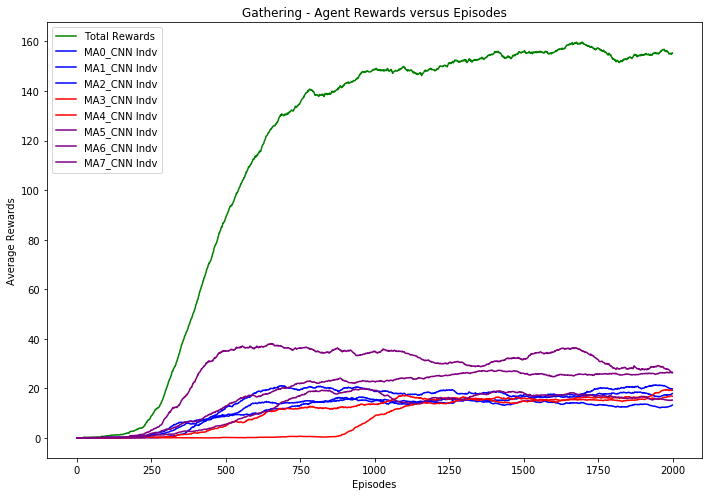

results/3T-8L1R/pacifist/p-0.1/
Max. Running Reward - MA0 Ind Reward: 20.366
Max. Running Reward - MA1 Ind Reward: 24.047
Max. Running Reward - MA2 Ind Reward: 26.096
Max. Running Reward - MA3 Ind Reward: 14.370
Max. Running Reward - MA4 Ind Reward: 18.448
Max. Running Reward - MA5 Ind Reward: 23.714
Max. Running Reward - MA6 Ind Reward: 28.853
Max. Running Reward - MA7 Ind Reward: 35.521
Max. Running Reward - All Agents: 162.030
Tribe 0 Sum Reward: 63.508
Tribe 1 Sum Reward: 30.831
Tribe 2 Sum Reward: 74.658




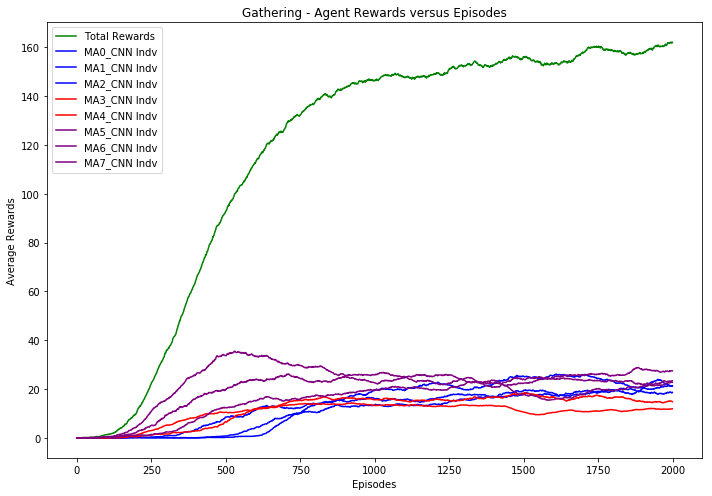

results/3T-8L1R/pacifist/p-1.0/
Max. Running Reward - MA0 Ind Reward: 15.946
Max. Running Reward - MA1 Ind Reward: 12.399
Max. Running Reward - MA2 Ind Reward: 0.143
Max. Running Reward - MA3 Ind Reward: 32.799
Max. Running Reward - MA4 Ind Reward: 35.157
Max. Running Reward - MA5 Ind Reward: 0.048
Max. Running Reward - MA6 Ind Reward: 29.989
Max. Running Reward - MA7 Ind Reward: 45.515
Max. Running Reward - All Agents: 156.087
Tribe 0 Sum Reward: 25.824
Tribe 1 Sum Reward: 66.532
Tribe 2 Sum Reward: 72.925




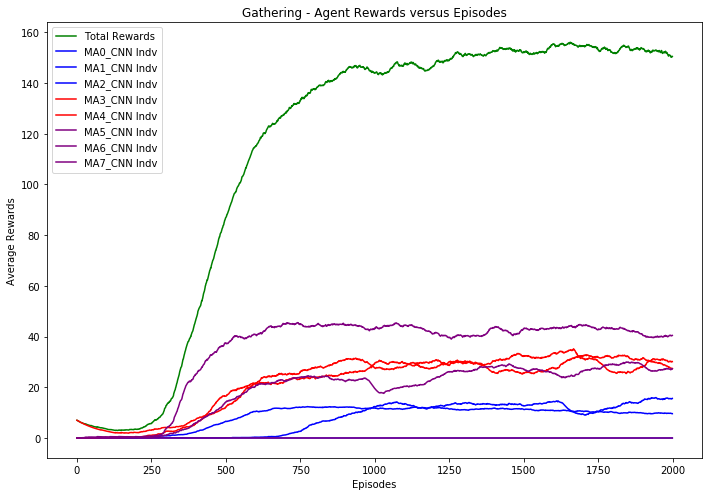

results/3T-8L1R/pacifist/p-10.0/
Max. Running Reward - MA0 Ind Reward: 19.327
Max. Running Reward - MA1 Ind Reward: 15.697
Max. Running Reward - MA2 Ind Reward: 12.784
Max. Running Reward - MA3 Ind Reward: 20.612
Max. Running Reward - MA4 Ind Reward: 28.924
Max. Running Reward - MA5 Ind Reward: 23.615
Max. Running Reward - MA6 Ind Reward: 32.336
Max. Running Reward - MA7 Ind Reward: 37.028
Max. Running Reward - All Agents: 158.747
Tribe 0 Sum Reward: 45.733
Tribe 1 Sum Reward: 41.890
Tribe 2 Sum Reward: 82.232




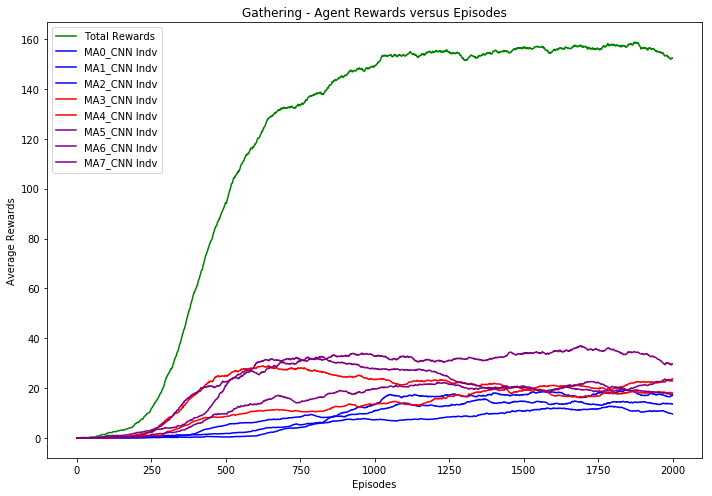

results/3T-8L1R/pacifist/p-100.0/
Max. Running Reward - MA0 Ind Reward: 19.143
Max. Running Reward - MA1 Ind Reward: 17.964
Max. Running Reward - MA2 Ind Reward: 24.746
Max. Running Reward - MA3 Ind Reward: 21.569
Max. Running Reward - MA4 Ind Reward: 16.561
Max. Running Reward - MA5 Ind Reward: 21.989
Max. Running Reward - MA6 Ind Reward: 29.390
Max. Running Reward - MA7 Ind Reward: 31.796
Max. Running Reward - All Agents: 168.842
Tribe 0 Sum Reward: 59.415
Tribe 1 Sum Reward: 36.701
Tribe 2 Sum Reward: 80.888




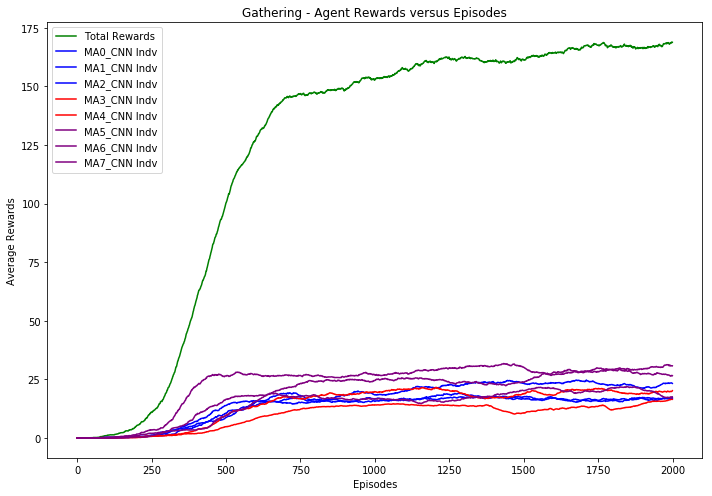

In [12]:
game = 'Gathering'

dir_names = ["results/3T-9L1R/pacifist/p-0.01/",
             "results/3T-9L1R/pacifist/p-0.1/", 
             "results/3T-9L1R/pacifist/p-1.0/",
             "results/3T-9L1R/pacifist/p-10.0/",
             "results/3T-9L1R/pacifist/p-100.0/"]

num_learners = 9
num_tribes = 3

# Cultural parameter search
culture = 'pacifist'

agents = []
for i in range(num_learners):
    print("Load AI agent {}".format(i))
    agents.append(Policy(4, 8, i))

agents.append(Rdn_Policy())

# Establish tribal association

tribes = []
tribes.append(Tribe(name='Vikings',color='blue', culture=culture, \
                    agents=[agents[0], agents[1], agents[2]]))
tribes.append(Tribe(name='Saxons', color='red', culture=culture, \
                    agents=[agents[3], agents[4], agents[5]]))
tribes.append(Tribe(name='Franks', color='purple', culture=culture, \
                    agents=[agents[6], agents[7], agents[8]]))
tribes.append(Tribe(name='Crazies', color='yellow', agents=[agents[9]]))   # random agents are crazy!!!


# 9 agents in 4 tribes
agent_colors = [agent.color for agent in agents]
agent_tribes = [agent.tribe for agent in agents]


for dir_name in dir_names:
    print (dir_name)
    data = [[] for i in range(num_learners)]
    tribe_data = [[] for i in range(num_tribes)]

    # Load rewards
    for i in range(num_learners):
        data_file = dir_name+'MA{}_Gather.p'.format(i, game)
        with open(data_file, 'rb') as f:
            data[i] = pickle.load(f)

    total = [sum(x) for x in zip(*data)]

    for i in range(num_learners):
        print('Max. Running Reward - MA{} Ind Reward: {:.3f}'.format(i, max(data[i])))

    
    print('Max. Running Reward - All Agents: {:.3f}'.format(max(total)))

    tribe_data[0] = [sum(x) for x in zip(data[0],data[1],data[2])]
    tribe_data[1] = [sum(x) for x in zip(data[3],data[4])]
    tribe_data[2] = [sum(x) for x in zip(data[5],data[6],data[7])]

    for i in range(num_tribes):
        print('Tribe {} Sum Reward: {:.3f}'.format(i, max(tribe_data[i])))
    
    print ('\n')

    plt.figure(figsize=(10, 7))
    plt.plot(total, label='Total Rewards', color='green')
    for i in range(num_learners):
        plt.plot(data[i], label='MA{}_CNN Indv'.format(i), color=agent_colors[i])

    plt.title('{} - Agent Rewards versus Episodes'.format(game))
    plt.xlabel('Episodes')
    plt.ylabel('Average Rewards')
    plt.legend()
    plt.tight_layout()
    plt.show()